__Use 20Newsgroups dataset [link] and do the following tasks:__

a) Run Stanford NER and Spacy NER and extract Named Entities from the data.


b) Find the top 100 LOC and PERSON entities from the data set. What is the degree of correlation between the two systems? Consider partial and full matches.


c) Generate Word2vec, Glove, Fasttext and BERT word vectors for the above corpus.


d) Use the NERs detected in Step (a). to create annotated documents for NER detection. Divide the document collection into training, validation and test data sets. Implement a custom NER systems (for all 4 vector embedding techniques mentioned in (c)) using
--> LSTM.
--> BERT.

Compare the results of the two systems on the test data collection for all embedding techniques.

e) Submit full documentation of the system - along with comparative performances of all the systems.


## Imports

In [ ]:
!pip install stanza

     |████████████████████████████████| 286kB 7.9MB/s 


In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3094831 sha256=e5660032403c5051627074da1ff967e83671b56d58bd4c458d3672e970afa885
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 225kB 10.1MB/s 
     |████████████████████████████████| 2.3MB 16.4MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 1.8MB 48.3MB/s 
     |████████████████████████████████| 225kB 50.8MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 122kB 58.5MB/s 
     |████████████████████████████████| 3.3MB 53.3MB/s 
     |████████████████████████████████| 8.2MB 30.8MB/s 
     |████████████████████████████████| 1.2MB 50.7MB/s 
     |████████████████████████████████| 901kB 43.7MB/s 
     |████████████████████████████████| 133kB 54.7MB/s 
     |████████████████████████████████| 174kB 58.7MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 245kB 37.9MB/s 
     |████████████████████████████████| 112kB 59.0MB/s 
     |████████████████████████████████| 112kB 48.9MB/s 
     |████████████████████████████████| 4.2MB 37.1M

In [ ]:
import stanza
import fasttext
import fasttext.util

In [ ]:
import random
import os
import re
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.display import display, HTML

import gensim
import spacy
from spacy import displacy
import en_core_web_sm

from collections import Counter
from sklearn.datasets import fetch_20newsgroups

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dropout, Activation, concatenate, Concatenate
from tensorflow.keras import regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import logging

import pandas as pd
from simpletransformers.ner import NERModel, NERArgs


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Load data

In [ ]:
newsgroup_data = fetch_20newsgroups(subset="all")

INFO:sklearn.datasets._twenty_newsgroups:Downloading 20news dataset. This may take a few minutes.
INFO:sklearn.datasets._twenty_newsgroups:Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


In [ ]:
# checking shape of the file
# The real data lies in the filenames and target attributes. 
print(newsgroup_data.filenames.shape, len(newsgroup_data.data))

(18846,) 18846


In [ ]:
# a single sample
print(newsgroup_data.data[0])
print("")

# remove \n and join all sentences
print(" ".join(newsgroup_data.data[0].split("\n")))

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!



From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu> Subject: Pens fans reactions Organization: 

### create dataframe

In [ ]:
df_data = pd.DataFrame({'text': [" ".join(doc.split("\n")) for doc in newsgroup_data.data]})
df_data.shape

(18846, 1)

In [ ]:
df_data.head(10)

,text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2,From: hilmi-er@dsv.su.se (Hilmi Eren) Subject:...
3,From: guyd@austin.ibm.com (Guy Dawson) Subject...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...
5,From: tell@cs.unc.edu (Stephen Tell) Subject: ...
6,From: lpa8921@tamuts.tamu.edu (Louis Paul Adam...
7,From: dchhabra@stpl.ists.ca (Deepak Chhabra) S...
8,From: dchhabra@stpl.ists.ca (Deepak Chhabra) S...
9,From: arromdee@jyusenkyou.cs.jhu.edu (Ken Arro...


### data cleaning 

In [ ]:
# clean data
def clean_df(df):
  # remove email starts
  df.text = df.text.replace(re.compile(r"From|\S*@\S*\s?|Subject"), "")

  # remove - and _ and :
  df.text = df.text.replace(re.compile("[\-_:]"), " ")

  # remove extra spaces
  df.text = df.text.replace(re.compile("\s+"), " ")

  # remove other chars
  df.text = df.text.replace(re.compile("[^a-zA-Z0-9\.,$ ]"), "")

  df.text = df.text.apply(lambda x: x.strip())

  return df
 

In [ ]:
# original text
text = " ".join(df_data.iloc[0].text.split("\n"))
# print(text)
text

"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu> Subject: Pens fans reactions Organization: Post Office, Carnegie Mellon, Pittsburgh, PA Lines: 12 NNTP-Posting-Host: po4.andrew.cmu.edu    I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am  bit puzzled too and a bit relieved. However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final regular season game.          PENS RULE!!!  "

In [ ]:
# test after cleaning
df = clean_df(df_data[:10].copy())
print(df.shape)

text = " ".join(df.iloc[0].text.split("\n"))
# print(text)
text

(10, 1)


'Mamatha Devineni Ratnam Pens fans reactions Organization Post Office, Carnegie Mellon, Pittsburgh, PA Lines 12 NNTP Posting Host po4.andrew.cmu.edu I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am bit puzzled too and a bit relieved. However, I am going to put an end to non PIttsburghers relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final regular season game. PENS RULE'

In [ ]:
%%time
# clean all data
df_data = clean_df(df_data)
print(df_data.shape)

(18846, 1)
CPU times: user 4.63 s, sys: 40.9 ms, total: 4.67 s
Wall time: 4.67 s


In [ ]:
df_data.head(10)

,text
0,Mamatha Devineni Ratnam Pens fans reactions Or...
1,Matthew B Lawson Which high performance VLB vi...
2,Hilmi Eren Re ARMENIA SAYS IT COULD SHOOT DOWN...
3,"Guy Dawson Re IDE vs SCSI, DMA and detach Orig..."
4,Alexander Samuel McDiarmid driver Organizatio...
5,Stephen Tell Re subliminal message flashing on...
6,Louis Paul Adams Re Number for Applied Enginee...
7,Deepak Chhabra Re Atlanta Hockey Hell Nntp Pos...
8,Deepak Chhabra Re Goalie masks Nntp Posting Ho...
9,Ken Arromdee Re Christians above the Law was C...


## Spacy NER

In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
print(spacy.explain('NORP'), '\n', spacy.explain('CARDINAL'))

Nationalities or religious or political groups 
 Numerals that do not fall under another type


we want to extract named entities and print in a dataframe 

In [ ]:
def show_ents(doc):
  if doc.ents:
    for ent in doc.ents:
      print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))   
  else: 
    print('No named entities found.')

In [ ]:
# doc = nlp('May I go to Washington DC next May to see the Washington Monument?') 
# # x =  [may, i, go , to, washington , dc, next, may, to, see, the, washington, monumemnt] 
# # y =  [o, o, o, o, b-loc, o, b-misc, i-misc, o, o, b-org, i-org, i-org] -> labels

# # doc = nlp("\n".join(newsgroup_train.data[0].split("\n")))
# show_ents(doc)

In [ ]:
example = nlp('Narendra Modi is Prime Minister of India')
show_ents(example)


Narendra Modi - PERSON - People, including fictional
India - GPE - Countries, cities, states


### Performing for one example

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
doc = nlp(df_data.iloc[0].text)

person_list = []
loc_list = []
ent_text = []
ent_label = []
ent_desr = []

for ent in doc.ents:
  ent_text.append(ent.text)
  ent_label.append(ent.label_)
  ent_desr.append(str(spacy.explain(ent.label_)))
  
  if ent.label_ == 'PERSON':
    person_list.append(ent.text)
  elif ent.label_ == 'LOC':
    loc_list.append(ent.text)
        
print(len(ent_text), len(ent_label), len(ent_desr), len(person_list))


14 14 14 3


In [ ]:
person_counts = Counter(person_list).most_common(100)
loc_counts = Counter(loc_list).most_common(100)

df_ent = pd.DataFrame(data = {'Text':ent_text,
                              'Label': ent_label,
                              'Description': ent_desr
                              }
                      )

df_person = pd.DataFrame(person_counts, columns =['Person', 'Count'])
df_location = pd.DataFrame(loc_counts, columns=['Location', 'Count'])

df_ent.shape, df_person.shape, df_location.shape

((14, 3), (3, 2), (1, 2))

#### saving and reading dataframe on drive

In [ ]:
df_ent

,Text,Label,Description
0,Devineni Ratnam,PERSON,"People, including fictional"
1,Pens,ORG,"Companies, agencies, institutions, etc."
2,Organization Post Office,ORG,"Companies, agencies, institutions, etc."
3,Carnegie Mellon,ORG,"Companies, agencies, institutions, etc."
4,Pittsburgh,GPE,"Countries, cities, states"
5,PA Lines,ORG,"Companies, agencies, institutions, etc."
6,Pens,ORG,"Companies, agencies, institutions, etc."
7,Devils,LOC,"Non-GPE locations, mountain ranges, bodies of ..."
8,PIttsburghers,ORG,"Companies, agencies, institutions, etc."
9,Pens,ORG,"Companies, agencies, institutions, etc."


In [ ]:
# saving the file
df_ent.to_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_ent.pkl')

In [ ]:
# reading the stored file
df_ent2 = pd.read_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_ent.pkl')

In [ ]:
df_ent2

,Text,Label,Description
0,Devineni Ratnam,PERSON,"People, including fictional"
1,Pens,ORG,"Companies, agencies, institutions, etc."
2,Organization Post Office,ORG,"Companies, agencies, institutions, etc."
3,Carnegie Mellon,ORG,"Companies, agencies, institutions, etc."
4,Pittsburgh,GPE,"Countries, cities, states"
5,PA Lines,ORG,"Companies, agencies, institutions, etc."
6,Pens,ORG,"Companies, agencies, institutions, etc."
7,Devils,LOC,"Non-GPE locations, mountain ranges, bodies of ..."
8,PIttsburghers,ORG,"Companies, agencies, institutions, etc."
9,Pens,ORG,"Companies, agencies, institutions, etc."


In [ ]:
# count of all labels
# df_ent['Label'].value_counts()

df_ent.Label.value_counts()

ORG       9
PERSON    3
GPE       1
LOC       1
Name: Label, dtype: int64

### for entire dataset

In [ ]:
%%time
person_list = []
loc_list = []

ent_doc_id = []
ent_text = []
ent_label = []
ent_desr = []


for i, text in enumerate(df_data.text.tolist()):
  # print(text, '\n')
  doc = nlp(text)
  # show_ents(doc)
  # print('\n')
  for ent in doc.ents:
    ent_doc_id.append(i)
    ent_text.append(ent.text)
    ent_label.append(ent.label_)
    ent_desr.append(str(spacy.explain(ent.label_)))
    
    if ent.label_ == 'PERSON':
      person_list.append(ent.text)
    elif ent.label_ == 'LOC':
      loc_list.append(ent.text)

print(len(ent_text), len(ent_label), len(ent_desr), len(person_list), len(loc_list))

516431 516431 516431 113138 4932
CPU times: user 31min 16s, sys: 35 s, total: 31min 51s
Wall time: 31min 46s


In [ ]:
person_counts = Counter(person_list).most_common(100)
loc_counts = Counter(loc_list).most_common(100)

df_ent = pd.DataFrame(data = {'doc_id': ent_doc_id,
                              'text':ent_text,
                              'label': ent_label,
                              'description': ent_desr
                              }
                      )

df_person = pd.DataFrame(person_counts, columns = ['person', 'cnt'])
df_location = pd.DataFrame(loc_counts, columns = ['location', 'cnt'])

df_ent.shape, df_person.shape, df_location.shape

((516431, 4), (100, 2), (100, 2))

In [ ]:
df_ent.head(20)

,doc_id,text,label,description
0,0,Devineni Ratnam,PERSON,"People, including fictional"
1,0,Organization:,ORG,"Companies, agencies, institutions, etc."
2,0,Carnegie Mellon,ORG,"Companies, agencies, institutions, etc."
3,0,Pittsburgh,GPE,"Countries, cities, states"
4,0,12,CARDINAL,Numerals that do not fall under another type
5,0,Devils,LOC,"Non-GPE locations, mountain ranges, bodies of ..."
6,0,Pens,ORG,"Companies, agencies, institutions, etc."
7,0,JAgr,PERSON,"People, including fictional"
8,0,Pens,ORG,"Companies, agencies, institutions, etc."
9,0,Jersey,PERSON,"People, including fictional"


In [ ]:
# saving the file
df_ent.to_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_ent_full.pkl')

In [ ]:
# reading the stored file
df_ent2 = pd.read_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_ent_full.pkl')

In [ ]:
df_ent2.tail()

,doc_id,text,label,description
516426,18845,Chris Silvester,PERSON,"People, including fictional"
516427,18845,|,PERSON,"People, including fictional"
516428,18845,Douglas Adams,PERSON,"People, including fictional"
516429,18845,Hitchhiker,ORG,"Companies, agencies, institutions, etc."
516430,18845,Galaxy,ORG,"Companies, agencies, institutions, etc."


In [ ]:
df_ent['label'].value_counts()

CARDINAL       117408
ORG            115251
PERSON         113138
GPE             46191
DATE            37411
NORP            25943
MONEY           11231
PRODUCT         10497
ORDINAL          8434
WORK_OF_ART      7690
LOC              4932
TIME             4434
FAC              3759
QUANTITY         3736
PERCENT          2807
LAW              1508
EVENT            1430
LANGUAGE          631
Name: label, dtype: int64

In [ ]:
df_ent[df_ent['label'] == 'PERSON'].shape

(113138, 4)

In [ ]:
 df_per = df_ent[df_ent['label'] == 'PERSON']

In [ ]:
# take out 100 persons from df_ent
df_per.shape

(113138, 4)

### top 100 LOC and PERSON entities

#### PERSON entities

In [ ]:
for i, row in df_person.iterrows():
  print(i, row['person'], row['cnt'])
  if i==100:
    break

0 Jesus 1631
1 Clinton 643
2 Paul 449
3 Mac 435
4 Sun 405
5 David 292
6 Mary 282
7 John 246
8 Keywords 244
9 Mike 232
10 Steve 218
11 Matthew 211
12 Windows 208
13 God 205
14 MYERS 198
15 Jim 193
16 Henry Spencer 188
17 Mark 185
18 Peter 175
19 Hitler 169
20 David Sternlight 166
21 Bill 164
22 Michael 158
23 Nntp-Posting-Host 154
24 David Koresh 153
25 Clayton Cramer 151
26 Xlib 147
27 Jesus Christ 147
28 Morris 146
29 Disclaimer 144
30 Rushdie 143
31 Roger 142
32 Law 139
33 Kent Sandvik 135
34 Bob 135
35 Pat 134
36 Moon 133
37 Bush 131
38 Nntp-Posting- 127
39 Dave 127
40 Brian 126
41 Sahak Melkonian - 1920 125
42 Ed 123
43 Frank O'Dwyer 120
44 Luke 119
45 Jake Livni 118
46 Kent 117
47 Gordon Banks 117
48 Waco 112
49 David Davidian 111
50 Quadra 111
51 Greeks 111
52 CWRU.Edu 109
53 Gary L Dare 108
54 Joseph 107
55 Tim Clock 105
56 David Veal 105
57 Keith Allan Schneider 101
58 Roger Maynard 101
59 Andrew 100
60 Don 99
61 Tom 98
62 NULL 98
63 Jon Livesey 95
64 Janet Reno 95
65 | 94
66 M

In [ ]:
df_person[76:]
# df_person[-25:]

,person,cnt
76,Ron,85
77,Phill Hallam-Baker,85
78,Dan,83
79,BATF,83
80,Mario,83
81,Chris BeHanna,82
82,George,82
83,Mark Singer,81
84,Ron Baalke,81
85,Ted,79


#### LOC entities

In [ ]:
df_location[:10]

,location,cnt
0,Earth,399
1,Europe,358
2,earth,203
3,Mars,142
4,Jupiter,118
5,Venus,109
6,East,72
7,West,67
8,Sun,62
9,Devils,47


In [ ]:
for i, row in df_location.iterrows():
  print(i, row['location'], row['cnt'])
  if i==100:
    break

0 Earth 399
1 Europe 358
2 earth 203
3 Mars 142
4 Jupiter 118
5 Venus 109
6 East 72
7 West 67
8 Sun 62
9 Devils 47
10 Marina 46
11 North America 44
12 Africa 32
13 Nope 30
14 the Middle East 28
15 BATF 28
16 Neptune 25
17 Karina 25
18 the middle east 24
19 Azerbaijanis 24
20 South Georgia Island 24
21 Asia 20
22 Erzurum 20
23 South 20
24 Strip 19
25 europe 19
26 Gulf 19
27 Nords 19
28 Atlantic 18
29 Kars 17
30 Xserver 17
31 Oilers 17
32 South America 17
33 Stanley Cup 17
34 Eastern Anatolia 17
35 the Stanley Cup 17
36 the Near East 16
37 Western Digital 16
38 Pacific 15
39 Psalms 15
40 Mathematica 15
41 the Middle-East 14
42 RE 14
43 Watts 14
44 the New Testament 14
45 North 14
46 Balkans 13
47 Titan 13
48 Delta 13
49 Holocaust 13
50 River 13
51 mideast 13
52 Macs 13
53 Southeastern Europe 13
54 Keywords 12
55 jupiter 12
56 the North Stars 12
57 New England 12
58 Gauche and Proud 12
59 Satan 12
60 Scandinavia 12
61 Middle East 12
62 the South Atlantic 12
63 Mediterranean 11
64 Sound 11

# Stanford NER

In [ ]:
stanza.download('en')
nlp_s = stanza.Pipeline('en')

2021-05-15 06:45:35 INFO: Downloading default packages for language: en (English)...
2021-05-15 06:47:01 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-05-15 06:47:02 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-05-15 06:47:02 INFO: Use device: gpu
2021-05-15 06:47:02 INFO: Loading: tokenize
2021-05-15 06:47:13 INFO: Loading: pos
2021-05-15 06:47:13 INFO: Loading: lemma
2021-05-15 06:47:13 INFO: Loading: depparse
2021-05-15 06:47:14 INFO: Loading: sentiment
2021-05-15 06:47:14 INFO: Loading: ner
2021-05-15 06:47:15 INFO: Done loading processors!


In [ ]:
nlp_s = stanza.Pipeline(lang='en', processors='tokenize,ner')

2021-05-15 06:47:40 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-05-15 06:47:40 INFO: Use device: gpu
2021-05-15 06:47:40 INFO: Loading: tokenize
2021-05-15 06:47:40 INFO: Loading: ner
2021-05-15 06:47:40 INFO: Done loading processors!


In [ ]:
def show_ents_stanford(text):
    doc = nlp_s(text)
    if doc.ents:
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.type )
    else: 
        print('No named entities found.')

In [ ]:
print(df_data.iloc[0].text)

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu> Subject: Pens fans reactions Organization: Post Office, Carnegie Mellon, Pittsburgh, PA Lines: 12 NNTP-Posting-Host: po4.andrew.cmu.edu    I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am  bit puzzled too and a bit relieved. However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final regular season game.          PENS RULE!!!  


In [ ]:
show_ents_stanford(text)

Chris Silvester - PERSON
Production Hold" - WORK_OF_ART
93 Firebird/Camaro - WORK_OF_ART
6 - CARDINAL
Netcom - Online Communication Services - ORG
408 - CARDINAL
241-9760 - CARDINAL
30 - CARDINAL
Gary Crum - PERSON
the Phone with "Pontiac Systems" - WORK_OF_ART
Pontaic Customer Service" - WORK_OF_ART
Production Hold - WORK_OF_ART
the Formula Firebird - PRODUCT
Trans Am - PRODUCT
a "Firebird Specialist" - WORK_OF_ART
first - ORDINAL
3:23 - CARDINAL
Second - ORDINAL
Manual - PRODUCT
Camaro - ORG
Chris S. -- - PERSON
Chris Silvester - PERSON
Douglas Adams - PERSON
The Hitchhiker's Guide to the Galaxy - WORK_OF_ART


In [ ]:
person_list = []
loc_list = []

ent_doc_id = []
ent_text = []
ent_type = []
ent_desr = []


for i, text in enumerate(df_data.text.tolist()):
  # print(text, '\n')
  # print(i)
  doc = nlp_s(text)
  # show_ents(doc)
  # print('\n')
  for ent in doc.ents:
    ent_doc_id.append(i)
    ent_text.append(ent.text)
    ent_type.append(ent.type)
    # ent_desr.append(str(spacy.explain(ent.label_)))
    
    if ent.type == 'PERSON':
      person_list.append(ent.text)
    elif ent.type == 'LOC':
      loc_list.append(ent.text)

print(len(ent_text), len(ent_type), len(person_list), len(loc_list))

450223 450223 96057 3498


In [ ]:
person_counts = Counter(person_list).most_common(100)
loc_counts = Counter(loc_list).most_common(100)

df_ent = pd.DataFrame(data = {'doc_id': ent_doc_id,
                              'text':ent_text,
                              'label': ent_type,
                              }
                      )

df_person = pd.DataFrame(person_counts, columns = ['person', 'cnt'])
df_location = pd.DataFrame(loc_counts, columns = ['location', 'cnt'])

df_ent.shape, df_person.shape, df_location.shape

((450223, 3), (100, 2), (100, 2))

In [ ]:
df_ent.head(20)

,doc_id,text,label
0,0,Mamatha Devineni,PERSON
1,0,Post Office,ORG
2,0,Carnegie Mellon,ORG
3,0,Pittsburgh,GPE
4,0,PA Lines,ORG
5,0,12,CARDINAL
6,0,Pens,ORG
7,0,Pens,ORG
8,0,PIttsburghers,NORP
9,0,Devils,NORP


In [ ]:
df_ent.to_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_ent_stanford.pkl')

In [ ]:
# reading the stored file
df_ent2 = pd.read_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_ent_stanford.pkl')

In [ ]:
df_ent2.head()

,doc_id,text,label
0,0,Mamatha Devineni,PERSON
1,0,Post Office,ORG
2,0,Carnegie Mellon,ORG
3,0,Pittsburgh,GPE
4,0,PA Lines,ORG


In [ ]:
df_ent['label'].value_counts()

ORG            101201
PERSON          96057
CARDINAL        89155
GPE             42291
DATE            27880
NORP            25061
PRODUCT         15863
MONEY            9728
WORK_OF_ART      9560
ORDINAL          8039
QUANTITY         6680
TIME             5237
PERCENT          3756
LOC              3498
FAC              2311
LAW              1807
EVENT            1501
LANGUAGE          598
Name: label, dtype: int64

### top 100 LOC and PERSON entities

##### PERSON entities

In [ ]:
df_person[76:]

,person,cnt
76,Gretzky,77
77,Mark Singer,76
78,Jake Livni,76
79,James,76
80,Clemens,76
81,King,75
82,Chris BeHanna,75
83,Chris,75
84,Michael Covington,74
85,Tony,74


#### LOC entities

In [ ]:
df_location[76:]

,location,cnt
76,Central America,6
77,the Golan Heights,6
78,Northern Israel,6
79,the Occupied Territories,6
80,Orient,6
81,Western Palestine,6
82,the Erevan guberniia,6
83,Central Vancouver Island,5
84,Islands,5
85,Gaza,5


# 3. Generate Word2vec, Glove, Fasttext and BERT word vectors for the above corpus.


In [ ]:
# converting list of list of  tokens to a single list
vocab = []
for word_list in df_annotated.tokens.tolist():
    # print(word_list)
    vocab.extend(word_list)

print("all words:", len(vocab))

# getting unique words into vocab list
vocab_set = list(set(vocab))
print("unique words:", len(vocab_set))


all words: 2625407
unique words: 140450


In [ ]:
# taking top 50k words 
vocab_cntr = Counter(vocab)
print(len(vocab_cntr))
vocab_50k = vocab_cntr.most_common(50000)
print(vocab_50k[:10]) 


140450
[('nt', 25975), ('lines', 19653), ('organization', 18632), ('writes', 13330), ('article', 12256), ('x', 9894), ('$', 9682), ('like', 9661), ('university', 9414), ('people', 9281)]


In [ ]:
# by looking at top and bottom 100 tokens we can do more pre-processing 
# take only tokens which has length greater than 1 and less than 15 characters
print(vocab_cntr.most_common()[:100])
print('\n')
print(vocab_cntr.most_common()[-100:])


[('nt', 25975), ('lines', 19653), ('organization', 18632), ('writes', 13330), ('article', 12256), ('x', 9894), ('$', 9682), ('like', 9661), ('university', 9414), ('people', 9281), ('posting', 9120), ('know', 8602), ('m', 8379), ('host', 8367), ('nntp', 8100), ('think', 7500), ('s', 7211), ('time', 6663), ('use', 6649), ('new', 6337), ('good', 5920), ('way', 5016), ('distribution', 4551), ('right', 4531), ('ve', 4479), ('system', 4476), ('god', 4382), ('d', 4322), ('want', 4185), ('world', 4160), ('reply', 4007), ('said', 3996), ('need', 3954), ('work', 3791), ('problem', 3599), ('computer', 3533), ('believe', 3431), ('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 3305), ('going', 3239), ('windows', 3211), ('help', 3162), ('find', 3154), ('file', 3145), ('state', 3143), ('information', 3137), ('mail', 3109), ('years', 3106), ('point', 3067), ('question', 3014), ('thanks', 2965), ('year', 2956), ('things', 2932), ('government', 2931), ('better', 2924), ('read', 2889), ('software', 2888), ('usa', 286

In [ ]:
# vocab_final = []
# for word, cnt in vocab_50k:
#     vocab_final.append(word)
# or
vocab_final = [word for word, cnt in vocab_50k]
print(len(vocab_final))


50000


## Fasttext

In [ ]:
fasttext.util.download_model('en', if_exists='ignore')

'cc.en.300.bin'

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
ft.get_dimension()

300

In [ ]:
# reducing dimension to 50
fasttext.util.reduce_model(ft, 50)
ft.get_dimension()

In [ ]:
ft.get_nearest_neighbors('microsoft', k=50)

[(0.805526077747345, 'microsft'),
 (0.7803288698196411, 'micrsoft'),
 (0.7566455006599426, 'microsofts'),
 (0.7424650192260742, 'mircosoft'),
 (0.6832096576690674, 'microsoft.'),
 (0.6750713586807251, 'Microsft'),
 (0.6660794615745544, 'Micrsoft'),
 (0.637310266494751, 'msft'),
 (0.6314657330513, 'Mircosoft'),
 (0.6286622881889343, 'symantec'),
 (0.6219303607940674, 'wordperfect'),
 (0.614840567111969, '-Microsoft'),
 (0.6141690611839294, 'Micorsoft'),
 (0.613628089427948, 'Microsofts'),
 (0.6108835339546204, 'Microsoft'),
 (0.6089588403701782, 'Miscrosoft'),
 (0.5983697175979614, 'Micosoft'),
 (0.5980483293533325, 'zune'),
 (0.5954290628433228, 'openoffice'),
 (0.5926812291145325, 'onedrive'),
 (0.5906116366386414, 'lindows'),
 (0.5858259201049805, 'windows8'),
 (0.5826097130775452, 'ballmer'),
 (0.5818806290626526, 'Msoft'),
 (0.5811493992805481, 'onenote'),
 (0.5780439972877502, 'Microsof'),
 (0.5779175758361816, 'msoffice'),
 (0.5768163800239563, 'Microsoft.'),
 (0.5724976062774658

In [ ]:
# even if the word is not present in fasttext vocabulory it will generate its embedding based on 
# sub-word (splitting words into chunks who's representation is known) model.
ft.get_nearest_neighbors('Applepedia')

[(0.5119317173957825,
  'MobileCOOLPADCUBOTDEXPDOOGEEElephoneEvercossGFIVEGIONEEHAIERHDCHisenseHTCHUAWEIINEWInnJooIntexJIAKEJIAYUKarbonnKataKingZoneLandvoLAVALeagooLeEcoLENOVOLGM-HorseMICROMAXMOTOROLAN0.1NEWMANOPPOORROOukitelQMobileReal'),
 (0.5012233853340149,
  'RossBreguetBreitlingBvlgariCartierChanelChopardCorumFranck'),
 (0.4882017970085144, 'ArabiaSenegalSeychellesSierra'),
 (0.4837532639503479, 'Stroudsburgwmhclarkfuneralhome.com'),
 (0.4766097962856293, 'MontenegroSeychellesSierra'),
 (0.47050416469573975, 'More56k6.6k126Softango'),
 (0.4693417251110077, 'ChanceSharpieSharproShortgrassSkechers'),
 (0.45837917923927307, 'MullerGrahamGucciHublotIWCJacob'),
 (0.4451282322406769, 'PilanesbergHluhluweKruger'),
 (0.44191640615463257, 'LionheartPulsePurfloQuinnyRainbowRecaroRed')]

In [ ]:
ft.get_nearest_neighbors('zxyzz')

[(0.4375116527080536,
  'QQFZAAEACwAAAAAGQASAAAIjgAJCBQIoGDBgQgTKiwooGHDgwshDgTgsOLDhAAGaAQwUYBBhx85EtS4cWLGjR5JSjxZkgDFkwwLohTJUqTLlANiwvQ4seVNjwwfBoVokKjFo0Jlksz506NFiklZtoQKFSjIoktLVv1YsahSn1WP0vzq02VYoAjJMsVYVKHZrDbdupW6Vq5cunHtRjQoMCAAIfkECRQABAAsCQADAAQABAAACAsABQgkILCgwYEBAQAh'),
 (0.41153204441070557, 'HorizonteBrasiliaCampinasCampo'),
 (0.40184900164604187, 'QuailDove'),
 (0.39256876707077026, '8923063edfe0b62061dceb045023e79b'),
 (0.3829341232776642, 'CauseDeadline'),
 (0.3820338547229767, 'KinshasaCook'),
 (0.37926164269447327,
  'Slavyansk-on-KubanTimashevskBelorechenskKrymskPrimorsko-AkhtarskTemryukGoryachy'),
 (0.3789069652557373, 'CityDaeguKwangjuSeoulUlsanYeosuVayama.com'),
 (0.3757433295249939, 'SteinermilestonesHeadlinesRasmusson-ImberyHeidt'),
 (0.3749874234199524,
  'deblogueroreflejoantecedentesexitlacuachebateysuteindesignableabsorbersexilatifundiosexibrezarsutemultiétnicosexiplinrapobrezarcorrentosoVd.lazadafisiochillidomabrezarsico-chuzaoutcolodrablogueroin')]

In [ ]:
def find_closest_embeddings(embed, word, k=10):
    if word in embed:
      return sorted(embed.keys(), key=lambda x: spatial.distance.euclidean(embed[x], embed[word]))[:k]
    return -1

In [ ]:
find_closest_embeddings(glove_embed, 'apple')

['apple',
 'macintosh',
 'iphone',
 'ipad',
 'instance',
 'timewrn',
 'microsoft',
 'intel',
 'ipod',
 'ibm']

In [ ]:
find_closest_embeddings('aarti')

## Word2Vec

In [ ]:
# download spacy model
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=28a5d0a9bac6212606a89007aa4160247cf887300fc680efe4648a29a70aa72a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7r68gr3i/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# load the spacy model
import en_core_web_lg
nlp = en_core_web_lg.load()

In [ ]:
doc = nlp("this is an apple sdsdf2342")

# sdsdf2342 is not a common word, so its not present in vocabulary of spacy and hence don't have vector
# spacy's en_core_web_lg package includes 685k unique vectors
# each token vector is of 300 dimension
for token in doc:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

this True 5.0461264 False
is True 4.890306 False
an True 5.5624833 False
apple True 7.1346846 False
sdsdf2342 False 0.0 True


In [ ]:
# Vector for document is average of vectors of individual token, so it's also of 300 dimension
token.vector.shape, doc.vector.shape

((300,), (300,))

In [ ]:
# converting list of list of  tokens to a single list
vocab = []
for word_list in df_annotated.tokens.tolist():
    # print(word_list)
    vocab.extend(word_list)

print("all words:", len(vocab))

# getting unique words into vocab list
vocab_set = list(set(vocab))
print("unique words:", len(vocab_set))



all words: 2625407
unique words: 140450


In [ ]:
# taking top 50k words 
vocab_cntr = Counter(vocab)
print(len(vocab_cntr))
vocab_50k = vocab_cntr.most_common(50000)
print(vocab_50k[:10]) 


140450
[('nt', 25975), ('lines', 19653), ('organization', 18632), ('writes', 13330), ('article', 12256), ('x', 9894), ('$', 9682), ('like', 9661), ('university', 9414), ('people', 9281)]


In [ ]:
# by looking at top and bottom 100 tokens we can do more pre-processing 
# take only tokens which has length greater than 1 and less than 15 characters
print(vocab_cntr.most_common()[:100])
print('\n')
print(vocab_cntr.most_common()[-100:])


[('nt', 25975), ('lines', 19653), ('organization', 18632), ('writes', 13330), ('article', 12256), ('x', 9894), ('$', 9682), ('like', 9661), ('university', 9414), ('people', 9281), ('posting', 9120), ('know', 8602), ('m', 8379), ('host', 8367), ('nntp', 8100), ('think', 7500), ('s', 7211), ('time', 6663), ('use', 6649), ('new', 6337), ('good', 5920), ('way', 5016), ('distribution', 4551), ('right', 4531), ('ve', 4479), ('system', 4476), ('god', 4382), ('d', 4322), ('want', 4185), ('world', 4160), ('reply', 4007), ('said', 3996), ('need', 3954), ('work', 3791), ('problem', 3599), ('computer', 3533), ('believe', 3431), ('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 3305), ('going', 3239), ('windows', 3211), ('help', 3162), ('find', 3154), ('file', 3145), ('state', 3143), ('information', 3137), ('mail', 3109), ('years', 3106), ('point', 3067), ('question', 3014), ('thanks', 2965), ('year', 2956), ('things', 2932), ('government', 2931), ('better', 2924), ('read', 2889), ('software', 2888), ('usa', 286

In [ ]:
# vocab_final = []
# for word, cnt in vocab_50k:
#     vocab_final.append(word)
# or
vocab_final = [word for word, cnt in vocab_50k]
print(len(vocab_final))


50000


In [ ]:
%%time
# get vector representation of example words
w2v_embed= list(nlp.pipe(['apple', 'organization', 'zzzzgfghasd'], disable=["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"]))
print(len(w2v_embed))

3
CPU times: user 126 ms, sys: 1.62 ms, total: 127 ms
Wall time: 130 ms


In [ ]:
w2v_embed[0].vector_norm, w2v_embed[1].vector_norm, w2v_embed[2].has_vector

(7.134684580188168, 6.468698891089936, True)

In [ ]:
w2v_embed[2].vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# each review is a vector dimension 300
reviews_w2v = np.array([review.vector for review in reviews_w2v])
reviews_w2v.shape

# Get All Vector Embeddings

In [ ]:
!cp /content/drive/MyDrive/NLP/embeddings/glove.6B.300d.txt /content/
!cp /content/drive/MyDrive/NLP/embeddings/wiki.simple.vec /content/
!cp /content/drive/MyDrive/NLP/embeddings/GoogleNews-vectors-negative300.bin.gz /content/

In [ ]:
def load_embeddings(embed_path, type="glove"):
    print(f'loading word vectors from: {embed_path}')
    embed = {}
    
    with open(embed_path) as f:
        # skip first line
        if type == "ft":
            n, d = map(int, f.readline().split())

        # space-separated text file in the format: word [vector of floats]
        for line in f:
            line = line.strip().split(' ')
            embed[line[0]] = np.asarray(line[1:], dtype='float32')

    print(f"\tembed word count: {len(embed)}")
    print(f"\tembed dim: {len(embed[line[0]])}")
    return embed


def built_embed_matrix(embed, word2idx, VOCAB_SIZE, EMBED_DIM, type=""):
    print('\nprepare embedding matrix...')

    embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
    embed_cnt = 0
    unk_words = []

    if type == "w2v":
      for word, idx in word2idx.items():
          try:
              embedding_vector = embed.get_vector(word)
              embedding_matrix[idx] = embedding_vector
              embed_cnt += 1
          except KeyError as e:
              unk_words.append((word, idx))

    else:
        for word, idx in word2idx.items():
            embedding_vector = embed.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
                embed_cnt += 1
            else:
                unk_words.append((word, idx))
          
                
    print(f"\tembedding matrix shape: {embedding_matrix.shape}")
    print(f"\tword embedding found: {embed_cnt}")
    print(f"\tword embedding not found: {len(unk_words)}")

    return embedding_matrix, unk_words
    

In [ ]:
!zcat GoogleNews-vectors-negative300.bin.gz | head -n 1

3000000 300


In [ ]:
!head glove.6B.300d.txt

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

In [ ]:
!head wiki.simple.vec

111051 300
</s> 0.28922 -0.46075 0.35142 -0.41104 0.16421 0.17307 -0.21562 -0.090636 -0.079495 -0.11149 0.030614 -0.0062959 0.14929 0.17588 0.023571 -0.13192 0.24037 -0.023433 -0.090424 -0.1205 0.15024 -0.04173 0.22556 0.0088108 0.037523 -0.023573 0.088627 -0.21427 0.012018 -0.057337 -0.029528 0.10135 0.1427 -0.20236 -0.046452 -0.16167 0.43107 -0.017859 -0.15654 0.14826 -0.034114 -0.14649 -0.091926 -0.16326 -0.08863 -0.057991 -0.12135 0.032937 0.20307 0.20069 0.256 -0.10217 -0.22534 -0.1053 -0.35453 0.047078 0.0064066 0.16062 0.30925 0.084114 -0.10756 0.27985 -0.13681 -0.1818 -0.23974 -0.015328 0.047659 0.18575 -0.05236 0.021459 -0.20396 0.16799 -0.164 -0.10783 0.15601 -0.12507 -0.043054 -0.12134 0.035488 -0.055631 -0.010796 -0.14874 -0.0087224 -0.10568 -0.10334 0.27871 0.072898 0.02437 -0.21292 -0.12933 0.13453 -0.29429 -0.012638 0.32057 -0.0036427 -0.0692 -0.041341 -0.082506 0.080206 -0.12415 0.098575 0.018395 -0.030875 0.14337 -0.031857 0.0083619 0.1698 -0.22698 0.018308 0.0070261 -

## GloVe

In [ ]:
EMBED_DIM = 300

glove_embed = load_embeddings("glove.6B.300d.txt")
glove_embed_matrix, glove_unknown_words = built_embed_matrix(glove_embed, word2idx, VOCAB_SIZE, EMBED_DIM)

loading word vectors from: glove.6B.300d.txt
	embed word count: 400000
	embed dim: 300

prepare embedding matrix...
	embedding matrix shape: (35000, 300)
	word embedding found: 29861
	word embedding not found: 5139


In [ ]:
# some words not found on glove embedding
glove_unknown_words[:10]

[('<unk>', 1),
 ('os2', 911),
 ('argic', 1122),
 ('xterm', 1360),
 ('vaxvms', 1517),
 ('pl8', 1548),
 ('x11r5', 1562),
 ('imho', 1615),
 ('34u', 1656),
 ('vnews', 1700)]

## FastText

In [ ]:
EMBED_DIM = 300

ft_embed = load_embeddings("wiki.simple.vec", type="ft")
ft_embed_matrix, ft_unknown_words = built_embed_matrix(ft_embed, word2idx, VOCAB_SIZE, EMBED_DIM)

loading word vectors from: wiki.simple.vec
	embed word count: 111023
	embed dim: 300

prepare embedding matrix...
	embedding matrix shape: (35000, 300)
	word embedding found: 24682
	word embedding not found: 10318


In [ ]:
# some words not found on fasttext embedding
ft_unknown_words[:10]

[('<unk>', 1),
 ('inc.', 122),
 ('1.1', 329),
 ('a.', 345),
 ('u.s.', 379),
 ('i.d.', 453),
 ('c.', 455),
 ('mr.', 465),
 ('j.', 466),
 ('d.', 566)]

## W2V

In [ ]:
EMBED_DIM = 300

w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
print("embed word count:", len(w2v.vocab))
print("embed dim:", w2v.vector_size)

w2v_embed_matrix, w2v_unknown_words = built_embed_matrix(w2v, word2idx, VOCAB_SIZE, EMBED_DIM, type="w2v")

embed word count: 3000000
embed dim: 300

prepare embedding matrix...
	embedding matrix shape: (35000, 300)
	word embedding found: 24746
	word embedding not found: 10254


In [ ]:
# some words not found on w2v embedding
w2v_unknown_words[:10]

[('<unk>', 1),
 ('nntp', 13),
 ('1.1', 329),
 ('armenians', 378),
 ('u.s.', 379),
 ('i.d.', 453),
 ('mr.', 465),
 ('j.', 466),
 ('i.e.', 575),
 ('koresh', 633)]

# Annotating documents 

In [ ]:
# for 1 sentence
doc = nlp("May I go to Washington DC next May to see the Washington Monument?") 

for e in doc.ents: 
  print(e.text, e.start, e.end, e.label_) 
print("")


Washington DC 4 6 GPE
next May 6 8 DATE
the Washington Monument 10 13 ORG



In [ ]:
# for list of sentences
texts = [
    "Net income was $9.4 million compared to the prior year of $2.7 million.",
    "May I go to Washington DC next May to see the Washington Monument?",
    "Is Rafael Nadal in Spain?"
]

for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    print([(ent.text, ent.start, ent.end, ent.label_) for ent in doc.ents])

[('$9.4 million', 3, 6, 'MONEY'), ('the prior year', 8, 11, 'DATE'), ('$2.7 million', 12, 15, 'MONEY')]
[('Washington DC', 4, 6, 'GPE'), ('next May', 6, 8, 'DATE'), ('the Washington Monument', 10, 13, 'ORG')]
[('Rafael Nadal', 1, 3, 'PERSON'), ('Spain', 4, 5, 'GPE')]


In [ ]:
# token labels
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    print([(token.text, token.ent_iob_, token.ent_type_) for token in doc])

[('Net', 'O', ''), ('income', 'O', ''), ('was', 'O', ''), ('$', 'B', 'MONEY'), ('9.4', 'I', 'MONEY'), ('million', 'I', 'MONEY'), ('compared', 'O', ''), ('to', 'O', ''), ('the', 'B', 'DATE'), ('prior', 'I', 'DATE'), ('year', 'I', 'DATE'), ('of', 'O', ''), ('$', 'B', 'MONEY'), ('2.7', 'I', 'MONEY'), ('million', 'I', 'MONEY'), ('.', 'O', '')]
[('May', 'O', ''), ('I', 'O', ''), ('go', 'O', ''), ('to', 'O', ''), ('Washington', 'B', 'GPE'), ('DC', 'I', 'GPE'), ('next', 'B', 'DATE'), ('May', 'I', 'DATE'), ('to', 'O', ''), ('see', 'O', ''), ('the', 'B', 'ORG'), ('Washington', 'I', 'ORG'), ('Monument', 'I', 'ORG'), ('?', 'O', '')]
[('Is', 'O', ''), ('Rafael', 'B', 'PERSON'), ('Nadal', 'I', 'PERSON'), ('in', 'O', ''), ('Spain', 'B', 'GPE'), ('?', 'O', '')]


In [ ]:
for token in doc:
    print(token, token.text, len(token), len(token.text.strip()))

Is Is 2 2
Rafael Rafael 6 6
Nadal Nadal 5 5
in in 2 2
Spain Spain 5 5
? ? 1 1


### single example

In [ ]:
nlp = en_core_web_sm.load(disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])
nlp.pipe_names

['ner']

In [ ]:
def get_annotated_text(text, remove_extra=False):
    doc_tokens = []
    doc_labels = []

    doc = nlp(text)
    
    for token in doc:
        # we can skip these tokens to reduce vocab size
        if remove_extra and any([token.is_digit, token.is_punct, token.is_stop, token.like_url, token.like_email]):
            # print(token)
            continue

        doc_tokens.append(token.text.lower())

        if token.ent_iob_ == 'O':
            doc_labels.append(token.ent_iob_)

        elif token.ent_type_ in ['LOC', 'ORG', 'PERSON']:
            doc_labels.append(token.ent_iob_ + '-' + token.ent_type_)

        elif token.ent_type_ == 'GPE':
            doc_labels.append(token.ent_iob_ + '-' + 'LOC')
        
        else:
            doc_labels.append(token.ent_iob_ + '-' + 'MISC')

        assert len(doc_tokens) == len(doc_tokens), "Length of tokens and labels are different"

    print(len(doc_tokens))
    print(list(zip(doc_tokens, doc_labels)))


#  ** Demo to get annotated text **

In [ ]:
df_data.head()

,text
0,Mamatha Devineni Ratnam Pens fans reactions Or...
1,Matthew B Lawson Which high performance VLB vi...
2,Hilmi Eren Re ARMENIA SAYS IT COULD SHOOT DOWN...
3,"Guy Dawson Re IDE vs SCSI, DMA and detach Orig..."
4,Alexander Samuel McDiarmid driver Organizatio...


In [ ]:
get_annotated_text(df_data.iloc[0].text.strip())

171
[('mamatha', 'O'), ('devineni', 'O'), ('ratnam', 'B-PERSON'), ('pens', 'I-PERSON'), ('fans', 'O'), ('reactions', 'O'), ('organization', 'B-ORG'), ('post', 'I-ORG'), ('office', 'I-ORG'), (',', 'O'), ('carnegie', 'B-ORG'), ('mellon', 'I-ORG'), (',', 'O'), ('pittsburgh', 'B-LOC'), (',', 'O'), ('pa', 'B-ORG'), ('lines', 'I-ORG'), ('12', 'O'), ('nntp', 'O'), ('posting', 'O'), ('host', 'O'), ('po4.andrew.cmu.edu', 'O'), ('i', 'O'), ('am', 'O'), ('sure', 'O'), ('some', 'O'), ('bashers', 'O'), ('of', 'O'), ('pens', 'O'), ('fans', 'O'), ('are', 'O'), ('pretty', 'O'), ('confused', 'O'), ('about', 'O'), ('the', 'O'), ('lack', 'O'), ('of', 'O'), ('any', 'O'), ('kind', 'O'), ('of', 'O'), ('posts', 'O'), ('about', 'O'), ('the', 'O'), ('recent', 'O'), ('pens', 'B-ORG'), ('massacre', 'O'), ('of', 'O'), ('the', 'O'), ('devils', 'B-LOC'), ('.', 'O'), ('actually', 'O'), (',', 'O'), ('i', 'O'), ('am', 'O'), ('bit', 'O'), ('puzzled', 'O'), ('too', 'O'), ('and', 'O'), ('a', 'O'), ('bit', 'O'), ('relieve

In [ ]:
get_annotated_text(df_data.iloc[0].text.strip(), remove_extra=True)

80
[('mamatha', 'O'), ('devineni', 'O'), ('ratnam', 'B-PERSON'), ('pens', 'I-PERSON'), ('fans', 'O'), ('reactions', 'O'), ('organization', 'B-ORG'), ('post', 'I-ORG'), ('office', 'I-ORG'), ('carnegie', 'B-ORG'), ('mellon', 'I-ORG'), ('pittsburgh', 'B-LOC'), ('pa', 'B-ORG'), ('lines', 'I-ORG'), ('nntp', 'O'), ('posting', 'O'), ('host', 'O'), ('sure', 'O'), ('bashers', 'O'), ('pens', 'O'), ('fans', 'O'), ('pretty', 'O'), ('confused', 'O'), ('lack', 'O'), ('kind', 'O'), ('posts', 'O'), ('recent', 'O'), ('pens', 'B-ORG'), ('massacre', 'O'), ('devils', 'B-LOC'), ('actually', 'O'), ('bit', 'O'), ('puzzled', 'O'), ('bit', 'O'), ('relieved', 'O'), ('going', 'O'), ('end', 'O'), ('non', 'O'), ('pittsburghers', 'B-ORG'), ('relief', 'O'), ('bit', 'O'), ('praise', 'O'), ('pens', 'B-ORG'), ('man', 'O'), ('killing', 'O'), ('devils', 'O'), ('worse', 'O'), ('thought', 'O'), ('jagr', 'O'), ('showed', 'O'), ('better', 'O'), ('regular', 'O'), ('season', 'O'), ('stats', 'O'), ('lot', 'O'), ('fo', 'O'), ('f

### creating annotated dataframe

In [ ]:
def get_annotated_df(df, remove_extra=False):
  tokens = []
  labels = []

  for doc in nlp.pipe(df.text):
    doc_tokens = []
    doc_labels = []

    for token in doc:
        # we can skip these tokens to reduce vocab size
        # if remove_extra and any([token.is_digit, token.is_punct, token.is_stop, token.like_url, token.like_email, len(token)<=1, len(token)>15]):
        if remove_extra and any([token.is_digit, token.is_punct, token.is_stop, token.like_url, token.like_email, 
                                 len(token.text.strip())<=1, len(token.text.strip())>15]):
            # print(token)
            continue

        doc_tokens.append(token.text.lower())

        if token.ent_iob_ == 'O':
            doc_labels.append(token.ent_iob_)

        elif token.ent_type_ in ['LOC', 'ORG', 'PERSON']:
            doc_labels.append(token.ent_iob_ + '-' + token.ent_type_)

        elif token.ent_type_ == 'GPE':
            doc_labels.append(token.ent_iob_ + '-' + 'LOC')
        
        else:
            doc_labels.append(token.ent_iob_ + '-' + 'MISC')

        assert len(doc_tokens) == len(doc_labels), "Length of tokens and labels are different"

    # append tokens and labels from doc to final list
    tokens.append(doc_tokens)
    labels.append(doc_labels)

  df['tokens'] = tokens
  df['labels'] = labels

  return df


In [ ]:
%%time
df_annotated = get_annotated_df(df_data, remove_extra=True)
print(df_annotated.shape)

(18846, 3)
CPU times: user 32min 25s, sys: 29 s, total: 32min 54s
Wall time: 32min 51s


In [ ]:
# saving
df_annotated.to_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_annotated_spacy.pkl')

In [ ]:
# reading
df_annotated = pd.read_pickle('/content/drive/MyDrive/NLP/NLP_Ass2/df_annotated_spacy.pkl')
df_annotated.shape

(18846, 3)

In [ ]:
display(HTML(df_annotated.sample(2).to_html()))

,text,tokens,labels
10929,"Eliza Strickler Re I donwloaded a .bin file from a unix machine now what Organization Georgia State University Lines 42 Nikolaus E Schuessler writes In article Eliza Strickler writes I just donwloaded a .bin file from a unix machine which is supposed to be converted to a MAC format. Does anyone know what I need to do to this file to get it into any Dos, Mac or Unix readable format. Someone mentioned fetch on the unix machine is this correct Could someone explain the .bin format a little This is almost certainly a MacBinary file which is an encoded version of a mac file so the Resource fork and Data fork get preserved. You need a program that converts this to a regular file. If this is a macbinary file, you may have downloaded it in Text mode and is probably corrupt if you did. If youre using FTP to transfer it at any point make sure you type binary first. If you can open the file with a text editor and find This file must be converted with Bin.... at the top, it is a BinHex file and can be decoded with BinHex 4.0 among other programs. I opened the file with a text editor and it looks like Vnetwork storyboardpictPICT8BIME...... I have already tried BinHex which does not seem to work. Any other ideas Niko Schuessler Project Vincent Systems Manager email Iowa State University Computation Center voice 515 294 1672 Ames IA 50011 snail 291 Durham 0 0 Elizabeth Strickler 0","[eliza, strickler, donwloaded, .bin, file, unix, machine, organization, georgia, state, university, lines, nikolaus, e, schuessler, writes, article, eliza, strickler, writes, donwloaded, .bin, file, unix, machine, supposed, converted, mac, format, know, need, file, dos, mac, unix, readable, format, mentioned, fetch, unix, machine, correct, explain, .bin, format, little, , certainly, macbinary, file, encoded, version, mac, file, resource, fork, data, fork, preserved, need, program, converts, regular, file, macbinary, file, downloaded, text, mode, probably, corrupt, ftp, transfer, point, sure, type, binary, open, file, text, editor, find, file, converted, bin, binhex, file, decoded, binhex, 4.0, programs, opened, file, text, editor, looks, like, vnetwork, storyboardpictpict8bime, tried, ...]","[B-PERSON, I-PERSON, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, B-MISC, I-MISC, I-MISC, O, O, B-PERSON, I-PERSON, O, O, O, O, O, O, O, O, B-ORG, O, O, O, O, B-ORG, B-PERSON, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, O, O, O, B-ORG, O, B-ORG, O, B-ORG, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, B-PERSON, O, O, O, O, O, O, O, O, O, O, O, O, B-PERSON, O, O, ...]"
8002,"Ken Kubey Re HBP BB BIG CAT Distribution na Organization Silicon Graphics, Inc., Mountain View, CA Lines 39 Nntp Posting Host summit.wpd.sgi.com In article writes Ken Kubey writes And finally, Id like to point out that many high OBP guys draw their walks more because pitchers are afraid to throw a strike to them, than because they have a great eye This comes up periodically, and I just dont get it. Take, for example, Mark McGwire. He walked 90 times in 1993. If thats not a potential great example of what youre talking about then I dont know what is. Now lets look at what happens when McGwire doesnt walk 75 of the time he made an out. 10 of the time he hit a single. 5 of the time he hit a double. 10 of the time he hit a homer. Now, youre pitching against McGwire. Would you trade 20 walks for 2 homers, 1 double, 2 singles, and 15 outs I would. Why give him the base when you can get him out 3 times out of 4 I didnt say that pitchers fear of throwing strikes to guys like McGwire, Bonds, and Frank Thomas was rational. I just said that it exists. Then there are guys like Alex Cole, who has a career .363 OBP even though hes never had a batting average over .300 he did hit .300 in 227 AB in 1990 or hit a single home run. Yep, thats right, hes never hit a homer in 916 ABs through the end of 1992. Whod be afraid to throw a strike to him I

# Creating Dataframe and then checking for annotation

In [ ]:
data_demo = ['Naredra Modi is Prime Minister of India. He recently visited U.K.']
df_demo = pd.DataFrame(data_demo, columns=['text'])
print(df_demo)
get_annotated_df(df_demo)


                                                text
0  Naredra Modi is Prime Minister of India. He re...


,text,tokens,labels
0,Naredra Modi is Prime Minister of India. He re...,"[naredra, modi, is, prime, minister, of, india...","[B-PERSON, I-PERSON, O, O, O, O, B-LOC, O, O, ..."


## Analyze NERS

In [ ]:
# all labels
labels = []

for sent_label in df_annotated.labels.tolist():
    labels.extend(sent_label)

Counter(labels)

Counter({'B-LOC': 44903,
         'B-MISC': 79194,
         'B-ORG': 99796,
         'B-PERSON': 101019,
         'I-LOC': 10734,
         'I-MISC': 53472,
         'I-ORG': 122826,
         'I-PERSON': 87038,
         'O': 1951871})

## Analyze vocab size

In [ ]:
tokens = []

for tl in df_annotated.tokens.tolist():
    tokens.extend(tl)

# all words in vocab
print("total tokens:", len(tokens))
print("total unique tokens:", len(set(tokens)))

total tokens: 2550853
total unique tokens: 131444


In [ ]:
# number of tokens with fequency >= 5
token_counter = Counter(tokens)

for freq in [2, 3, 5, 10]:
    temp = [elem for elem in token_counter.most_common() if elem[1]>=freq]
    print(f"tokens occuring >={freq} times:", len(temp))

tokens occuring >=2 times: 66551
tokens occuring >=3 times: 48292
tokens occuring >=5 times: 34153
tokens occuring >=10 times: 21497


## Analyze Token Lengths

In [ ]:
df_annotated['num_tokens'] = df_annotated['tokens'].apply(lambda x: len(x))
df_annotated['num_labels'] = df_annotated['labels'].apply(lambda x: len(x))

df_annotated["tokens_joined"] = df_annotated.tokens.apply(lambda x: " ".join(x))
df_annotated['num_tokens_joined'] = df_annotated['tokens_joined'].apply(lambda x: len(x.split()))

In [ ]:
df_annotated[df_annotated.num_tokens != df_annotated.num_labels].head()

,text,tokens,labels,num_tokens,num_labels,tokens_joined,num_tokens_joined


In [ ]:
df_annotated[df_annotated.num_tokens_joined != df_annotated.num_labels].head()

,text,tokens,labels,num_tokens,num_labels,tokens_joined,num_tokens_joined


In [ ]:
# stats for num length 
df_annotated['num_tokens'].describe()

count    18846.000000
mean       135.352489
std        259.944006
min          7.000000
25%         54.000000
50%         84.000000
75%        135.000000
max       6194.000000
Name: num_tokens, dtype: float64

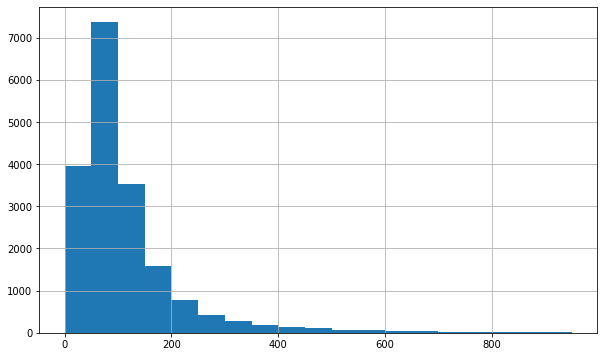

In [ ]:
df_annotated.num_tokens.hist(bins = range(0, 1000, 50), figsize = (10, 6))

# build train/test data

In [ ]:
# to make experiments comparable, we set the seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
df_annotated.head()

,text,tokens,labels,num_tokens,num_labels,tokens_joined,num_tokens_joined
0,Mamatha Devineni Ratnam Pens fans reactions Or...,"[mamatha, devineni, ratnam, pens, fans, reacti...","[O, O, B-PERSON, I-PERSON, O, O, B-ORG, I-ORG,...",80,80,mamatha devineni ratnam pens fans reactions or...,80
1,Matthew B Lawson Which high performance VLB vi...,"[matthew, lawson, high, performance, vlb, vide...","[B-PERSON, I-PERSON, O, O, B-ORG, O, O, B-ORG,...",76,76,matthew lawson high performance vlb video card...,76
2,Hilmi Eren Re ARMENIA SAYS IT COULD SHOOT DOWN...,"[hilmi, eren, armenia, says, shoot, turkish, p...","[O, O, O, O, B-ORG, O, O, O, O, O, O, O, O, O,...",276,276,hilmi eren armenia says shoot turkish planes h...,276
3,"Guy Dawson Re IDE vs SCSI, DMA and detach Orig...","[guy, dawson, ide, vs, scsi, dma, detach, orig...","[B-PERSON, I-PERSON, O, O, O, O, O, B-ORG, I-O...",237,237,guy dawson ide vs scsi dma detach originator o...,237
4,Alexander Samuel McDiarmid driver Organizatio...,"[alexander, samuel, mcdiarmid, driver, organiz...","[B-PERSON, I-PERSON, I-PERSON, O, B-ORG, I-ORG...",68,68,alexander samuel mcdiarmid driver organization...,68


In [ ]:
# split data into train/test
df_train, df_test = train_test_split(df_annotated, test_size=0.20, random_state=SEED)
df_train.shape, df_test.shape

((15076, 7), (3770, 7))

In [ ]:
x_train = df_train.tokens_joined.values
y_train = df_train.labels.values

x_test = df_test.tokens_joined.values
y_test = df_test.labels.values

len(x_train), len(y_train), len(x_test), len(y_test)

(15076, 15076, 3770, 3770)

In [ ]:
train_labels = []
test_labels = []

for sent_label in y_train:
    train_labels.extend(sent_label)

for sent_label in y_test:
    test_labels.extend(sent_label) 

In [ ]:
Counter(train_labels)

Counter({'B-LOC': 35865,
         'B-MISC': 62079,
         'B-ORG': 79461,
         'B-PERSON': 80080,
         'I-LOC': 8664,
         'I-MISC': 42424,
         'I-ORG': 97946,
         'I-PERSON': 69066,
         'O': 1546828})

In [ ]:
Counter(test_labels)

Counter({'B-LOC': 9038,
         'B-MISC': 17115,
         'B-ORG': 20335,
         'B-PERSON': 20939,
         'I-LOC': 2070,
         'I-MISC': 11048,
         'I-ORG': 24880,
         'I-PERSON': 17972,
         'O': 405043})

### tokenize data 

In [ ]:
# after analyzing above vocab stats, we set our vocab size to be 35k
VOCAB_SIZE = 35000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>", filters='')

# we fit tokenizer on x_train data
tokenizer.fit_on_texts(x_train)

x_train_idx = tokenizer.texts_to_sequences(x_train)
x_train_tok = tokenizer.sequences_to_texts(x_train_idx)

x_test_idx = tokenizer.texts_to_sequences(x_test)
x_test_tok = tokenizer.sequences_to_texts(x_test_idx)

len(x_train_idx), len(x_train_tok), len(x_test_idx), len(x_test_tok)

(15076, 15076, 3770, 3770)

In [ ]:
# displays a rendom sent and ids
def display_sample(x_tok, x_idx, y, k=None):
    if not k:
        k = random.randint(0, len(x_tok))
    print("k:", k)
    print("length of toks and idx:", len(x_tok[k].split()), len(x_idx[k]), len(y[k]))
    print("labels:", y[k])
    print("sent tok:", x_tok[k].split())
    print("sent idx:", x_idx[k])

In [ ]:
display_sample(x_train_tok, x_train_idx, y_train)

k: 10931
length of toks and idx: 53 53 53
labels: ['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
sent tok: ['charles', 'sundheim', 'wanted', 'police', 'officers', 'answer', 'posting', 'nntp', 'posting', 'host', 'ursa', 'organization', 'calvin', 'college', 'lines', 'dan', 'sorenson', 'writes', '<unk>', 'heh', 'attitude', 'stopped', 'speaking', 'guy', 'recieved', 'verbal', 'warning', 'mph', 'laugh', 'hey', 'dan', 'potentially', 'cool', 'story', 'stuff', 'share', 'details', 'break', 'probably', 'nt', 'enlighten', '<unk>', 'let', 'live', '<unk>', '<unk>', 'story', 'erc', '<unk>', 'mi', 'usa', 'vfr750f', 'dod']
sent idx: [1053, 13363, 274, 317, 1948, 214, 10, 13, 10, 12, 17494, 4, 7068, 267, 3, 776, 5770, 5

In [ ]:
display_sample(x_test_tok, x_test_idx, y_test)

k: 164
length of toks and idx: 69 69 69
labels: ['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'O', 'O', 'B-LOC', 'B-ORG', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'B-ORG', 'O', 'O', 'B-MISC', 'B-MISC', 'O', 'O', 'B-MISC', 'O', 'B-ORG', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'B-ORG', 'O', 'O', 'B-MISC', 'O', 'O', 'B-PERSON', 'O']
sent tok: ['dave', 'tharp', 'cds', 'volvo', 'attack', 'distribution', 'na', 'organization', 'tektronix', 'colorado', 'data', 'systems', 'englewood', 'co', 'lines', 'article', 'writes', 'cookson', 'writes', 'rocket', 'launchers', 'vfr', 'batf', 'having', 'fire', 'sale', 'waco', 'tx', 'try', 'try', 'newsgroup', 'interesting', 'stuff', 'probably', 'classified', 'artillery', 'dave', 'tharp', 'dod', 'nt', 'wear', 'mra', 'indian', 'scout', 'k75s', 'indian', 'chief', 'a

### pad data

In [ ]:
# we need to add <pad> token with index 0 to tokenizer.word_index 
tokenizer.word_index.update({'<pad>':0})
tokenizer.index_word.update({0:'<pad>'})

# since tokenizer.word_index has all words > we get only what's under VOCAB_SIZE
word2idx = {w:idx for w,idx in tokenizer.word_index.items() if idx < VOCAB_SIZE}
idx2word = {idx:w for w,idx in word2idx.items()}

# adjust VOCAB_SIZE
VOCAB_SIZE = len(word2idx)

print("len word2idx: ", len(word2idx))
print("len idx2word: ", len(idx2word))
print("vocab size: ", VOCAB_SIZE)
print("")

len word2idx:  35000
len idx2word:  35000
vocab size:  35000



In [ ]:
# check idx2word and word2idx mapping
list(zip(list(word2idx.items())[:10], list(idx2word.items())[:10]))

[(('<unk>', 1), (1, '<unk>')),
 (('nt', 2), (2, 'nt')),
 (('lines', 3), (3, 'lines')),
 (('organization', 4), (4, 'organization')),
 (('writes', 5), (5, 'writes')),
 (('article', 6), (6, 'article')),
 (('like', 7), (7, 'like')),
 (('university', 8), (8, 'university')),
 (('people', 9), (9, 'people')),
 (('posting', 10), (10, 'posting'))]

### encode labels

In [ ]:
possible_labels = ['O', 'B-PERSON', 'I-PERSON', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

lbl2idx = {lbl:i for i,lbl in enumerate(possible_labels)}
idx2lbl = {i:lbl for lbl,i in lbl2idx.items()}

len(lbl2idx), len(idx2lbl)

(9, 9)

In [ ]:
lbl2idx

{'B-LOC': 5,
 'B-MISC': 7,
 'B-ORG': 3,
 'B-PERSON': 1,
 'I-LOC': 6,
 'I-MISC': 8,
 'I-ORG': 4,
 'I-PERSON': 2,
 'O': 0}

In [ ]:
# replace <unk> tokens by 'O' 
y_train_idx = []
y_test_idx = []

for i in range(len(x_train_idx)):
    for j in range(len(x_train_idx[i])):
        if x_train_idx[i][j] == 1 or x_train_idx[i][j] == 0:
            y_train[i][j] = 'O'
    y_train_idx.append([lbl2idx[lbl] for lbl in y_train[i]])

for i in range(len(x_test_idx)):
    for j in range(len(x_test_idx[i])):
        if x_test_idx[i][j] == 1 or x_test_idx[i][j] == 0:
            y_test[i][j] = 'O'
    y_test_idx.append([lbl2idx[lbl] for lbl in y_test[i]])
                          
len(y_train), len(y_train_idx), len(y_test), len(y_test_idx)

(15076, 15076, 3770, 3770)

In [ ]:
display_sample(x_train_tok, x_train_idx, y_train, 1)

k: 1
length of toks and idx: 41 41 41
labels: ['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O']
sent tok: ['max', 'j.', '<unk>', 'speeding', 'ticket', 'chp', 'organization', '<unk>', 'lines', 'interesting', 'fight', 'ticket', 'chance', 'cop', 'wo', 'nt', 'secondly', 'point', 'lied', '<unk>', 'ticket', 'beleive', 'yore', 'charged', 'going', 'mph', 'posted', 'speed', 'severe', 'ticket', 'nt', 'possibly', 'going', 'right', 'max', 'j.', '<unk>', 'uunet', '<unk>', 'protect', 'want']
sent idx: [1146, 466, 1, 6642, 1933, 18572, 4, 1, 3, 454, 1247, 1933, 664, 3071, 253, 2, 4263, 41, 8161, 1, 1933, 4923, 34720, 3396, 35, 1868, 450, 225, 2979, 1933, 2, 1042, 35, 20, 1146, 466, 1, 3226, 1, 880, 25]


In [ ]:
# we set MAX_SEQ_LEN analyzing the sequence length: mean: 144 and median: 90
MAX_SEQ_LEN = 150

# pad sequences so that we get a N x MAX_SEQ_LEN matrix
x_train_idx_padded = pad_sequences(x_train_idx, maxlen=MAX_SEQ_LEN, padding='post', truncating='post', value=0)
x_test_idx_padded = pad_sequences(x_test_idx, maxlen=MAX_SEQ_LEN, padding='post', truncating='post', value=0)

y_train_idx_padded = pad_sequences(y_train_idx, maxlen=MAX_SEQ_LEN, padding='post', truncating='post', value=0)
y_test_idx_padded = pad_sequences(y_test_idx, maxlen=MAX_SEQ_LEN, padding='post', truncating='post', value=0)

print(x_train_idx_padded.shape, y_train_idx_padded.shape, x_test_idx_padded.shape, y_test_idx_padded.shape)

(15076, 150) (15076, 150) (3770, 150) (3770, 150)


In [ ]:
print(x_train_idx_padded[1])
print(y_train_idx_padded[1])
print(tokenizer.sequences_to_texts([x_train_idx_padded[1]]))

[ 1146   466     1  6642  1933 18572     4     1     3   454  1247  1933
   664  3071   253     2  4263    41  8161     1  1933  4923 34720  3396
    35  1868   450   225  2979  1933     2  1042    35    20  1146   466
     1  3226     1   880    25     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[1 2 0 0 0 3 4 0 4 4 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 1 2 0
 0 0 0 0 0 

In [ ]:
print(x_test_idx_padded[1])
print(y_test_idx_padded[1])
print(tokenizer.sequences_to_texts([x_test_idx_padded[1]]))

[22102  9905 14619     4  1741   856  1259   382  1436     3     6  7031
     5     7  2757  2208   735    11    18   300  1077     1 25028    56
   300   631    55    54 24767   678 24767   678  2309   233    18  2030
   667   151   128  6081  7143     1     1   735  6798 11491     1  8207
    50  1480  6685  1173  5060    65   632  5498   632   243    98    82
    25   739     1 13799  2370    38  5055   703  5258  1616 25028  5687
  1095 24767   678   467  1303 22102  9905  4550     1   139  4962   331
 14111  2220 15179     1  4424     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[3 4 4 4 4 4 4 4 0 7 0 3 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 7 0 7 0 0 0 0 0 0
 0 0 0 0 0 

Create annotated documents for NER detection.
Divide the document collection into training, validation and test data sets. 

a) Implement a custom NER system for

(i) LSTM with word2vec

(ii) LSTM with glove

(iii) LSTM with fast text

(iv) LSTM with BERT embeddings.



b) Implement a BERT based NER model. Compare the result of this model with those obtained in (d- (i))


# Bi-LSTM based NER model using glove embedding
 


In [ ]:
label_idxs = []
for lbls in y_train_idx:
    label_idxs.extend(lbls)

Counter(label_idxs)

Counter({0: 1586599,
         1: 74434,
         2: 60044,
         3: 72842,
         4: 93841,
         5: 33265,
         6: 8286,
         7: 53762,
         8: 39340})

In [ ]:
class_weights = compute_class_weight('balanced', np.unique(label_idxs), label_idxs)
print(class_weights)

class_weights = {i:round(val,4) for i,val in enumerate(class_weights)}
class_weights

[ 0.1416316   3.01895042  3.74246479  3.08493116  2.39460956  6.75522488
 27.11954569  4.17976555  5.71206293]


{0: 0.1416,
 1: 3.019,
 2: 3.7425,
 3: 3.0849,
 4: 2.3946,
 5: 6.7552,
 6: 27.1195,
 7: 4.1798,
 8: 5.7121}

In [ ]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        

def build_lstm_model(embedding_matrix, EMBED_DIM, NUM_LABELS, loss):

    input_ = Input(shape=(MAX_SEQ_LEN,), name="input")

    embed_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length = MAX_SEQ_LEN,
                      weights=[embedding_matrix], trainable=False, mask_zero=True)(input_)

    lstm_layer = Bidirectional(LSTM(units=64, return_sequences=True, dropout=.1, recurrent_dropout=0.1,
                               kernel_regularizer = regularizers.l2(0.01)), name="lstm")(embed_layer)

    out = TimeDistributed(Dense(NUM_LABELS, activation="softmax"))(lstm_layer) 
    model = Model(input_, out)

    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = loss, 
                  metrics= ["accuracy"]) 
    
    return model


### train on GloVe embeddings

In [ ]:
NUM_LABELS = len(possible_labels)
NUM_LABELS

9

In [ ]:
lstm_model_glove = build_lstm_model(glove_embed_matrix, 300, 9, 'sparse_categorical_crossentropy')
lstm_model_glove.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 150, 300)          10500000  
_________________________________________________________________
lstm (Bidirectional)         (None, 150, 128)          186880    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 150, 9)            1161      
Total params: 10,688,041
Trainable params: 188,041
Non-trainable params: 10,500,000
_________________________________________________________________


In [ ]:
monitor_para = "val_accuracy"
model_save_dir = "lstm_glove/"

if not os.path.isdir(model_save_dir):
    os.mkdir(model_save_dir)

filepath = model_save_dir + "%s-improve-{epoch:02d}-{%s:.4f}.hdf5" % (monitor_para, monitor_para)

log_history = LossHistory()
checkpoint = ModelCheckpoint(filepath, monitor=monitor_para, verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0, verbose=1, restore_best_weights=True)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
history = lstm_model_glove.fit(x_train_idx_padded, y_train_idx_padded,
                             batch_size = BATCH_SIZE,
                             epochs = EPOCHS,
                             # class_weight = class_weights,
                             callbacks = [checkpoint, early_stopping, log_history],
                             validation_data = (x_test_idx_padded, y_test_idx_padded)
                             )

Epoch 1/10
118/118 [==============================] - 177s 1s/step - loss: 3.5576 - accuracy: 0.7348 - val_loss: 0.5231 - val_accuracy: 0.8007

Epoch 00001: val_accuracy improved from -inf to 0.80066, saving model to lstm_glove/val_accuracy-improve-01-0.8007.hdf5
Epoch 2/10
118/118 [==============================] - 170s 1s/step - loss: 0.4791 - accuracy: 0.8018 - val_loss: 0.3928 - val_accuracy: 0.8218

Epoch 00002: val_accuracy improved from 0.80066 to 0.82177, saving model to lstm_glove/val_accuracy-improve-02-0.8218.hdf5
Epoch 3/10
118/118 [==============================] - 169s 1s/step - loss: 0.3953 - accuracy: 0.8191 - val_loss: 0.3703 - val_accuracy: 0.8316

Epoch 00003: val_accuracy improved from 0.82177 to 0.83161, saving model to lstm_glove/val_accuracy-improve-03-0.8316.hdf5
Epoch 4/10
118/118 [==============================] - 170s 1s/step - loss: 0.3781 - accuracy: 0.8252 - val_loss: 0.3584 - val_accuracy: 0.8350

Epoch 00004: val_accuracy improved from 0.83161 to 0.83499

In [ ]:
drive_folder = "/content/drive/MyDrive/NLP/NLP_Ass2/models/" + model_save_dir
if not os.path.isdir(drive_folder):
    os.mkdir(drive_folder)

!cp /content/lstm_glove/val_accuracy-improve-10-0.8425.hdf5 $drive_folder

In [ ]:
hist_glove = pd.DataFrame(history.history)
hist_glove

,loss,accuracy,val_loss,val_accuracy
0,2.014132,0.769962,0.523122,0.800662
1,0.442136,0.808138,0.392828,0.821773
2,0.390364,0.819999,0.370269,0.831606
3,0.374430,0.825234,0.358375,0.834994
4,0.365458,0.828500,0.350900,0.837056
5,0.358693,0.831056,0.345370,0.837203
6,0.353764,0.833363,0.341048,0.840506
7,0.349927,0.834539,0.337881,0.838649
8,0.346542,0.835741,0.334412,0.842304
9,0.343710,0.836972,0.331175,0.842486


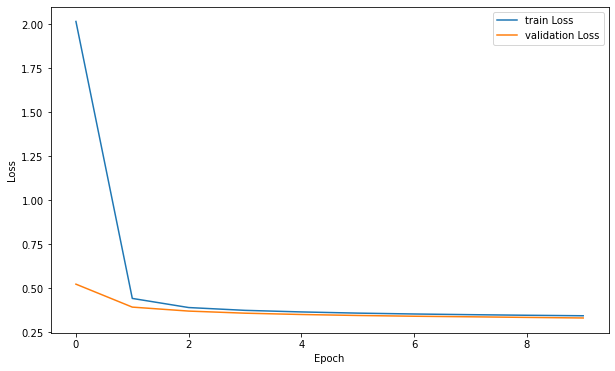

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist_glove.loss, label="train Loss")
plt.plot(hist_glove.val_loss, label="validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

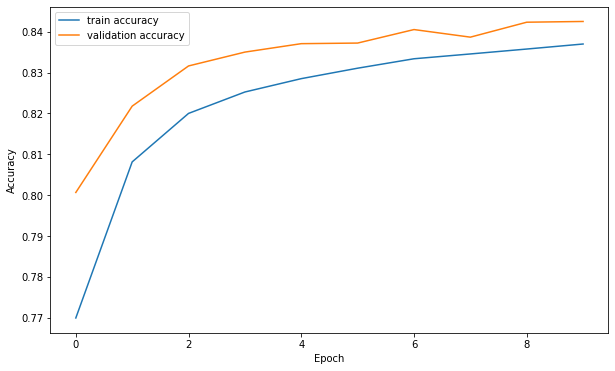

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist_glove.accuracy, label="train accuracy")
plt.plot(hist_glove.val_accuracy, label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

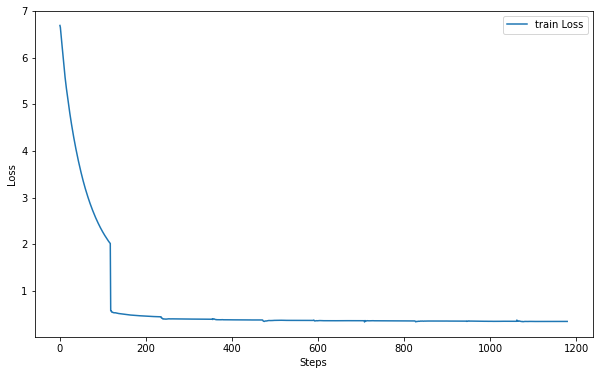

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(log_history.losses, label="train Loss")
#plt.plot(log_history.val_losses, label="validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

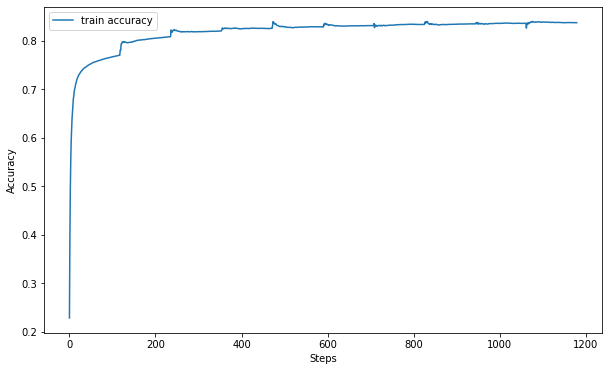

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(log_history.accuracies, label="train accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### evaluate

In [ ]:
y_test_pred = lstm_model_glove.predict(x_test_idx_padded)
y_test_pred_idx = y_test_pred.argmax(axis=-1)

y_test_pred.shape, y_test_pred_idx.shape

((3770, 150, 9), (3770, 150))

In [ ]:
y_test_flatten = []
y_pred_flatten = []

for t_list,p_list in zip(y_test_idx, y_test_pred_idx):
    l = min(MAX_SEQ_LEN, len(t_list))
    y_test_flatten.extend(t_list[:l])
    y_pred_flatten.extend(p_list[:l])

len(y_test_flatten), len(y_pred_flatten)

(340903, 340903)

In [ ]:
print('\nClassification Report:')
print(classification_report(y_test_flatten, y_pred_flatten))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    264415
           1       0.79      0.63      0.70     13608
           2       0.71      0.62      0.66     11417
           3       0.51      0.12      0.19     12478
           4       0.61      0.48      0.54     18275
           5       0.58      0.32      0.41      5246
           6       0.56      0.05      0.10      1176
           7       0.73      0.29      0.41      8049
           8       0.78      0.20      0.32      6239

    accuracy                           0.84    340903
   macro avg       0.68      0.41      0.47    340903
weighted avg       0.82      0.84      0.82    340903



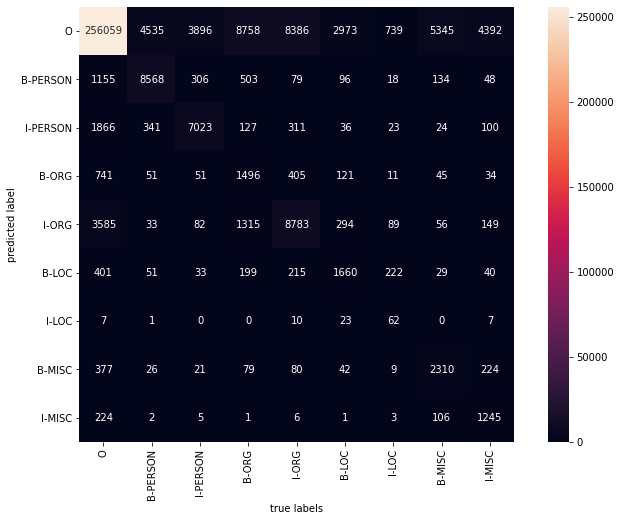

In [ ]:
mat = confusion_matrix(y_test_flatten, y_pred_flatten)
plt.figure(figsize=(12,8))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",  xticklabels=possible_labels, yticklabels=possible_labels)
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

In [ ]:
def display_predictions(x, y, y_pred):
    tokens = [idx2word[i] for i in x]
    y_lbl = [idx2lbl[i] for i in y]
    y_pred_lbl = [idx2lbl[i] for i in y_pred]

    print("{:15} :{:10} :{}".format("Word", "True", "Pred"))
    print("-"*35)

    for tok, o, p in zip(tokens[:MAX_SEQ_LEN], y_lbl, y_pred_lbl):
        print(f"{tok:15} {o:10} {p}")
        # we only want words till ENDPAD
        if tok == "<pad>":
            break  

In [ ]:
k =  random.randint(0, len(x_train_idx_padded)-1)
display_infer(x_train_idx_padded[k], y_train_idx_padded[k], y_train_pred_idx[k])

Word            :True       :Pred
-----------------------------------
['art', '<unk>', 'quadra', 'scsi', 'problems', 'organization', 'stratus', 'computers', 'inc.', 'lines', 'distribution', 'world', 'nntp', 'posting', 'host', 'article', '<unk>', 'van', 'der', 'linden', 'writes', 'like', 'info', 'anybody', 'exabyte', 'tapedrive', 'working', 'quadra', 'trying', 'september', 'replaced', 'cabling', 'inits', 'nt', 'know', 'industry', 'experts', 'phoned', 'tapedrive', 'dealer', 'apple', 'dealer', 'software', 'dealer', 'fault', 'nt', 'know', 'thing', 'said', 'needed', 'special', 'quadra', 'scsi', 'terminator', 'anybody', 'know', 'thanks', 'article', 'mark', 'h.', 'nodine', 'wrote', 'article', 'bill', 'johnston', 'writes', 'article', 'mark', 'h.', 'nodine', 'writes', 'nt', 'know', 'specific', 'problem', 'mentioned', 'message', 'definitely', 'scsi', 'problems', 'q700', 'venerable', 'jasmine', 'megadrive', 'cartridge', 'drives', 'solution', 'silverlining', 'loops', 'involved', 'blind', 'writes',

In [ ]:
neg_idx = y_test==1
print(y_pred[neg_idx][:20])

[[0.93985164]
 [0.96505076]
 [0.9508675 ]
 [0.9591978 ]
 [0.9921793 ]
 [0.9853513 ]
 [0.35582128]
 [0.9858087 ]
 [0.71300066]
 [0.3687348 ]
 [0.99865025]
 [0.60092634]
 [0.77743816]
 [0.9465676 ]
 [0.93626773]
 [0.84705675]
 [0.9578289 ]
 [0.9746558 ]
 [0.9705723 ]
 [0.9758438 ]]


### train on fastText embeddings

In [ ]:
lstm_model_ft = build_lstm_model(ft_embed_matrix, 300, 9, 'sparse_categorical_crossentropy')
lstm_model_ft.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 300)          10500000  
_________________________________________________________________
lstm (Bidirectional)         (None, 150, 128)          186880    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 150, 9)            1161      
Total params: 10,688,041
Trainable params: 188,041
Non-trainable params: 10,500,000
_________________________________________________________________


In [ ]:
monitor_para = "val_accuracy"
model_save_dir = "lstm_ft/"

if not os.path.isdir(model_save_dir):
    os.mkdir(model_save_dir)

filepath = model_save_dir + "%s-improve-{epoch:02d}-{%s:.4f}.hdf5" % (monitor_para, monitor_para)

log_history = LossHistory()
checkpoint = ModelCheckpoint(filepath, monitor=monitor_para, verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0, verbose=1, restore_best_weights=True)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
history = lstm_model_ft.fit(x_train_idx_padded, y_train_idx_padded,
                             batch_size = BATCH_SIZE,
                             epochs = EPOCHS,
                             #class_weight = class_weights,
                             callbacks = [checkpoint, early_stopping, log_history],
                             validation_data = (x_test_idx_padded, y_test_idx_padded)
                             )

Epoch 1/10
118/118 [==============================] - 170s 1s/step - loss: 0.3701 - accuracy: 0.8269 - val_loss: 0.3553 - val_accuracy: 0.8333

Epoch 00001: val_accuracy improved from -inf to 0.83329, saving model to lstm_ft/val_accuracy-improve-01-0.8333.hdf5
Epoch 2/10
118/118 [==============================] - 170s 1s/step - loss: 0.3627 - accuracy: 0.8300 - val_loss: 0.3479 - val_accuracy: 0.8373

Epoch 00002: val_accuracy improved from 0.83329 to 0.83729, saving model to lstm_ft/val_accuracy-improve-02-0.8373.hdf5
Epoch 3/10
118/118 [==============================] - 171s 1s/step - loss: 0.3564 - accuracy: 0.8322 - val_loss: 0.3434 - val_accuracy: 0.8407

Epoch 00003: val_accuracy improved from 0.83729 to 0.84074, saving model to lstm_ft/val_accuracy-improve-03-0.8407.hdf5
Epoch 4/10
118/118 [==============================] - 172s 1s/step - loss: 0.3522 - accuracy: 0.8339 - val_loss: 0.3400 - val_accuracy: 0.8414

Epoch 00004: val_accuracy improved from 0.84074 to 0.84145, saving 

In [ ]:
drive_folder = "/content/drive/MyDrive/NLP/NLP_Ass2/models/" + model_save_dir
if not os.path.isdir(drive_folder):
    os.mkdir(drive_folder)

!cp /content/lstm_ft/val_accuracy-improve-10-0.8447.hdf5 $drive_folder

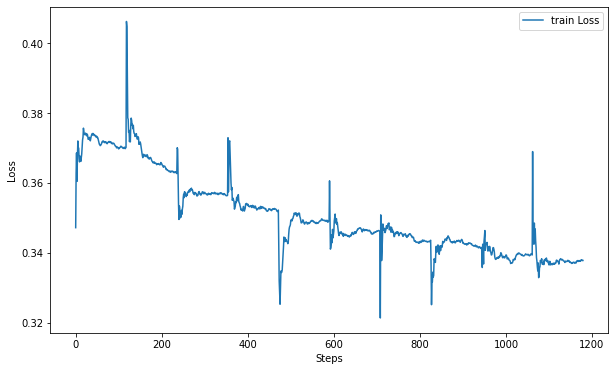

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(log_history.losses, label="train Loss")
#plt.plot(log_history.val_losses, label="validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

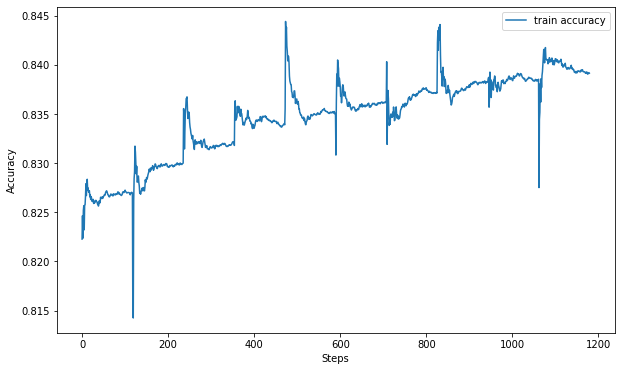

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(log_history.accuracies, label="train accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
hist_ft = pd.DataFrame(history.history)
hist_ft

,loss,accuracy,val_loss,val_accuracy
0,0.370114,0.826937,0.355265,0.833290
1,0.362663,0.830010,0.347950,0.837288
2,0.356423,0.832188,0.343369,0.840741
3,0.352202,0.833906,0.340019,0.841448
4,0.349236,0.834995,0.337299,0.842817
5,0.346058,0.836196,0.334602,0.841266
6,0.343556,0.837145,0.331699,0.844648
7,0.341457,0.838244,0.330600,0.841773
8,0.339345,0.838539,0.328731,0.843756
9,0.337773,0.839163,0.325996,0.844665


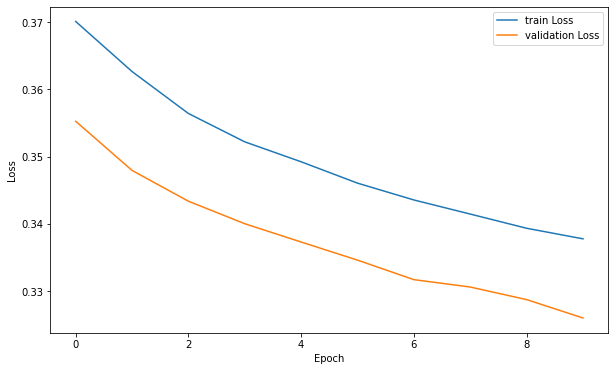

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist_ft['loss'], label="train Loss")
plt.plot(hist_ft['val_loss'], label="validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

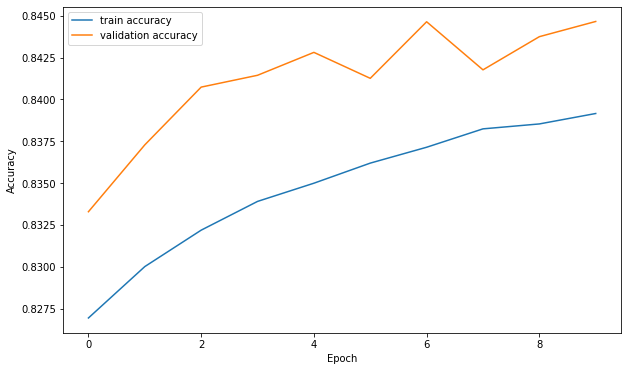

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist_ft['accuracy'], label="train accuracy")
plt.plot(hist_ft['val_accuracy'], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### evaluate

In [ ]:
y_test_pred = lstm_model_ft.predict(x_test_idx_padded)
y_test_pred_idx = y_test_pred.argmax(axis=-1)

y_test_pred.shape, y_test_pred_idx.shape

((3770, 150, 9), (3770, 150))

In [ ]:
y_test_flatten = []
y_pred_flatten = []

for t_list,p_list in zip(y_test_idx, y_test_pred_idx):
    l = min(MAX_SEQ_LEN, len(t_list))
    y_test_flatten.extend(t_list[:l])
    y_pred_flatten.extend(p_list[:l])

len(y_test_flatten), len(y_pred_flatten)

(340903, 340903)

In [ ]:
print('\nClassification Report:')
print(classification_report(y_test_flatten, y_pred_flatten))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.23      0.36    264415
           1       0.03      0.04      0.04     13608
           2       0.04      0.05      0.05     11417
           3       0.07      0.02      0.03     12478
           4       0.06      0.02      0.03     18275
           5       0.01      0.16      0.02      5246
           6       0.00      0.03      0.01      1176
           7       0.03      0.27      0.05      8049
           8       0.03      0.23      0.05      6239

    accuracy                           0.20    340903
   macro avg       0.12      0.12      0.07    340903
weighted avg       0.66      0.20      0.29    340903



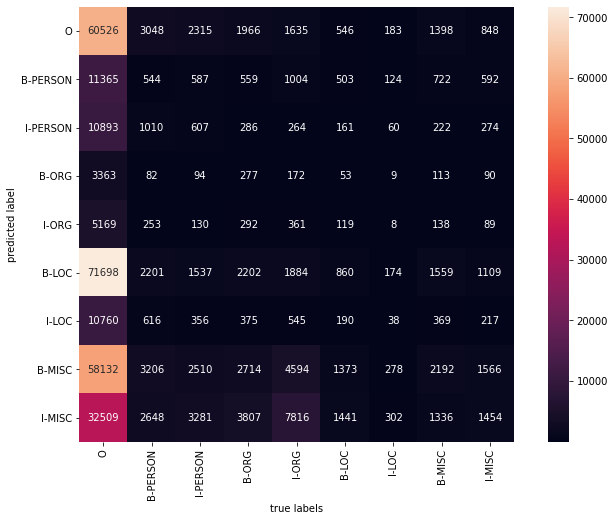

In [ ]:
mat = confusion_matrix(y_test_flatten, y_pred_flatten)
plt.figure(figsize=(12,8))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",  xticklabels=possible_labels, yticklabels=possible_labels)
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()


### train on Word2Vec embeddings

In [ ]:
lstm_model_w2v = build_lstm_model(w2v_embed_matrix, 300, 9, 'sparse_categorical_crossentropy')
lstm_model_w2v.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 150, 300)          10500000  
_________________________________________________________________
lstm (Bidirectional)         (None, 150, 128)          186880    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 150, 9)            1161      
Total params: 10,688,041
Trainable params: 188,041
Non-trainable params: 10,500,000
_________________________________________________________________


In [ ]:
monitor_para = "val_accuracy"
model_save_dir = "lstm_w2v/"

if not os.path.isdir(model_save_dir):
    os.mkdir(model_save_dir)

filepath = model_save_dir + "%s-improve-{epoch:02d}-{%s:.4f}.hdf5" % (monitor_para, monitor_para)

log_history = LossHistory()
checkpoint = ModelCheckpoint(filepath, monitor=monitor_para, verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0, verbose=1, restore_best_weights=True)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 5
history = lstm_model_w2v.fit(x_train_idx_padded, y_train_idx_padded,
                             batch_size = BATCH_SIZE,
                             epochs = EPOCHS,
                             #class_weight = class_weights,
                             callbacks = [checkpoint, early_stopping, log_history],
                             validation_data = (x_test_idx_padded, y_test_idx_padded)
                             )

Epoch 1/5
118/118 [==============================] - 175s 1s/step - loss: 3.6289 - accuracy: 0.7337 - val_loss: 0.5824 - val_accuracy: 0.7775

Epoch 00001: val_accuracy improved from -inf to 0.77751, saving model to lstm_w2v/val_accuracy-improve-01-0.7775.hdf5
Epoch 2/5
118/118 [==============================] - 168s 1s/step - loss: 0.5386 - accuracy: 0.7782 - val_loss: 0.4471 - val_accuracy: 0.8034

Epoch 00002: val_accuracy improved from 0.77751 to 0.80336, saving model to lstm_w2v/val_accuracy-improve-02-0.8034.hdf5
Epoch 3/5
118/118 [==============================] - 168s 1s/step - loss: 0.4490 - accuracy: 0.8003 - val_loss: 0.4180 - val_accuracy: 0.8134

Epoch 00003: val_accuracy improved from 0.80336 to 0.81342, saving model to lstm_w2v/val_accuracy-improve-03-0.8134.hdf5
Epoch 4/5
118/118 [==============================] - 169s 1s/step - loss: 0.4263 - accuracy: 0.8086 - val_loss: 0.4031 - val_accuracy: 0.8186

Epoch 00004: val_accuracy improved from 0.81342 to 0.81862, saving m

In [ ]:
drive_folder = "/content/drive/MyDrive/NLP/Project/models/" + model_save_dir
if not os.path.isdir(drive_folder):
    os.mkdir(drive_folder)

!cp /content/lstm_w2v/val_accuracy-improve-06-0.8671.hdf5 $drive_folder

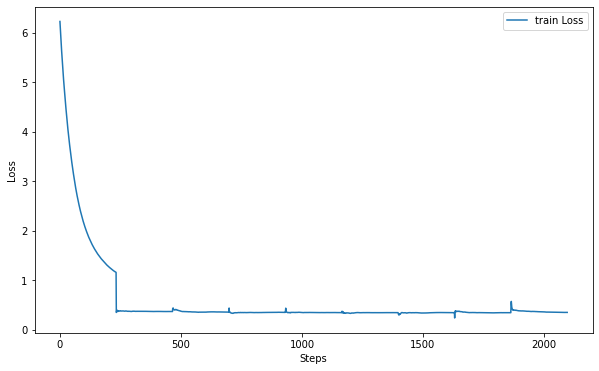

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(log_history.losses, label="train Loss")
#plt.plot(log_history.val_losses, label="validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

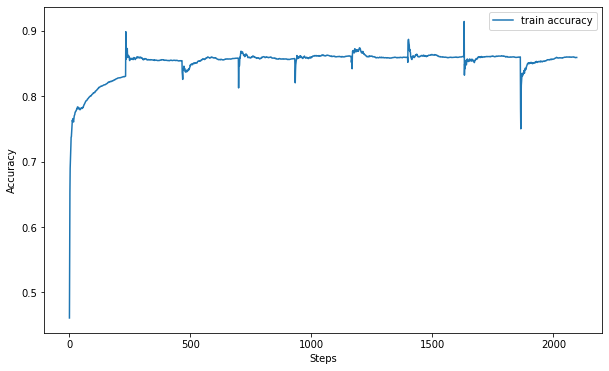

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(log_history.accuracies, label="train accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
hist_w2v = pd.DataFrame(history.history)
hist_w2v

,loss,accuracy,val_loss,val_accuracy
0,1.155980,0.830505,0.404795,0.844735
1,0.363984,0.854175,0.456955,0.832211
2,0.351928,0.857946,0.353166,0.850660
3,0.346971,0.857340,0.358914,0.854026
4,0.342683,0.860774,0.362760,0.847697
5,0.341434,0.859394,0.330429,0.867089
6,0.340885,0.860303,0.366448,0.852680
7,0.340587,0.859832,0.489938,0.776596
8,0.346300,0.859057,0.331504,0.862375


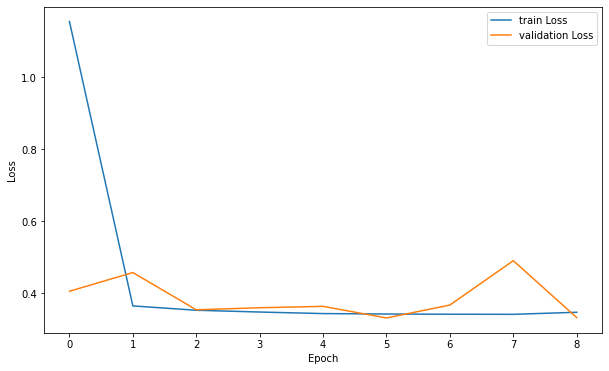

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist_w2v['loss'], label="train Loss")
plt.plot(hist_w2v['val_loss'], label="validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

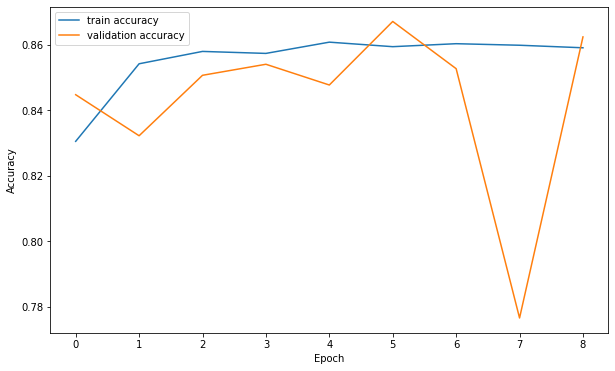

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist_w2v['accuracy'], label="train accuracy")
plt.plot(hist_w2v['val_accuracy'], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### evaluate

In [ ]:
y_test_pred = lstm_model_w2v.predict(x_test_idx_padded)
y_test_pred_idx = y_test_pred.argmax(axis=-1)

y_test_pred.shape, y_test_pred_idx.shape

((3770, 150, 9), (3770, 150))

In [ ]:
y_test_flatten = []
y_pred_flatten = []

for t_list,p_list in zip(y_test_idx, y_test_pred_idx):
    l = min(MAX_SEQ_LEN, len(t_list))
    y_test_flatten.extend(t_list[:l])
    y_pred_flatten.extend(p_list[:l])

len(y_test_flatten), len(y_pred_flatten)

(340903, 340903)

In [ ]:
print('\nClassification Report:')
print(classification_report(y_test_flatten, y_pred_flatten))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.23      0.36    264415
           1       0.03      0.04      0.04     13608
           2       0.04      0.05      0.05     11417
           3       0.07      0.02      0.03     12478
           4       0.06      0.02      0.03     18275
           5       0.01      0.16      0.02      5246
           6       0.00      0.03      0.01      1176
           7       0.03      0.27      0.05      8049
           8       0.03      0.23      0.05      6239

    accuracy                           0.20    340903
   macro avg       0.12      0.12      0.07    340903
weighted avg       0.66      0.20      0.29    340903



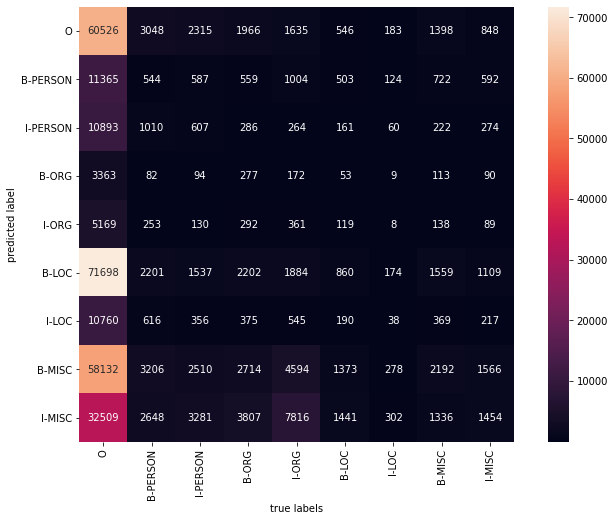

In [ ]:
mat = confusion_matrix(y_test_flatten, y_pred_flatten)
plt.figure(figsize=(12,8))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",  xticklabels=possible_labels, yticklabels=possible_labels)
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

# BERT based NER model

In [ ]:
import logging
from simpletransformers.ner import NERModel, NERArgs

ModuleNotFoundError: ignored

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:


train_data = [
    [0, "Harry", "B-PER"],
    [0, "Potter", "I-PER"],
    [0, "was", "O"],
    [0, "a", "O"],
    [0, "student", "B-MISC"],
    [0, "at", "O"],
    [0, "Hogwarts", "B-LOC"],
    [1, "Albus", "B-PER"],
    [1, "Dumbledore", "I-PER"],
    [1, "founded", "O"],
    [1, "the", "O"],
    [1, "Order", "B-ORG"],
    [1, "of", "I-ORG"],
    [1, "the", "I-ORG"],
    [1, "Phoenix", "I-ORG"],
]
train_data = pd.DataFrame(
    train_data, columns=["sentence_id", "words", "labels"]
)

eval_data = [
    [0, "Sirius", "B-PER"],
    [0, "Black", "I-PER"],
    [0, "was", "O"],
    [0, "a", "O"],
    [0, "prisoner", "B-MISC"],
    [0, "at", "O"],
    [0, "Azkaban", "B-LOC"],
    [1, "Lord", "B-PER"],
    [1, "Voldemort", "I-PER"],
    [1, "founded", "O"],
    [1, "the", "O"],
    [1, "Death", "B-ORG"],
    [1, "Eaters", "I-ORG"],
]
eval_data = pd.DataFrame(
    eval_data, columns=["sentence_id", "words", "labels"]
)

# Configure the model
model_args = NERArgs()
model_args.train_batch_size = 16
model_args.evaluate_during_training = True

model = NERModel(
    "roberta", "roberta-base", args=model_args
)

# Train the model
model.train_model(train_data, eval_data=eval_data)

# Evaluate the model
result, model_outputs, preds_list = model.eval_model(eval_data)

# Make predictions with the model
predictions, raw_outputs = model.predict(["Hermione was the best in her class"])
